# 🟦 **Cross-Selling Analyis - Data Preparation and EDA for E-Commerce Pet Shop**  
### Focus: Cross-Selling Analysis  

In this notebook, we will prepare the dataset and perform **Exploratory Data Analysis (EDA)**.  
The main objective is to clean the data, create **fact & dimension tables**, and calculate key metrics for **cross-selling opportunities**.  

---

**<u>Raw Dataset:</u>**  

We will work with three main tables:  

**Sales Table**  
Contains information about each sale, the customer, and the product.  
- Transaction Date  
- Customer ID  
- Description  
- Stock Code  
- Invoice No  
- Quantity  
- Sales  
- Unit Price  

**State Mapping Table**  
Maps different state code variations to a standardized format.  
- Order State  
- State  
- Region  

**Product Table**  
Contains product attributes and cost details.  
- Stock Code  
- Weight  
- Landed Cost  
- Shipping Cost (1000 miles)  
- Description  
- Category  

---

### **Scenario**  
The **Marketing Department** requested an analysis to identify product pairs that are frequently purchased together.  
The goal is to align cross-selling strategies with the company’s objectives:  
- Increase **sales** through bundle promotions  
- Maximize **profit** by focusing on high-margin combinations  
- Improve **customer experience** by recommending meaningful product pairs  
- Support **data-driven merchandising** and **commercial decision-making**  

---

### **Data Layers in this Project**  

## 1. **Staging Layer**  
  - Load CSVs into Cloud Storage & BigQuery  
  - Create raw tables  
  - Perform uniqueness checks  
  - Trim & standardize columns  
  - No cleaning yet (only preparation)  
---

## 2. **Intermediate Layer**  
- The data is cleaned and standardized across all tables.  
- Missing values are handled and documented.  
- Datatypes for join keys are standardized.  
- Range checks are performed for numerical columns (e.g. quantity > 0, sales > 0, unit_price > 0).  
- Final step: all tables are **joined together** to create a consolidated dataset.  

Purpose: Provide a **clean, consistent, and validated dataset** for downstream analytics.  

---

## 3. **Datamart Layer**  

This is the **business-ready dataset** for the **cross-selling use case**.  

**Final Main Table**   
- Metrics created:  
  - Number of transactions containing cross-selling activity
  - Average cross-selling price
  - Revenue generated from cross-selling combinations
  - Profit generated from cross-selling combinations
  - Profit margin from cross-selling transactions
  - Cross-selling rate (share of transactions with paired purchases)
  - Support (how often a product/product pair appears in transactions)
  - Confidence (likelihood that B is purchased when A is bought)
  - Lift (strength of the A→B relationship beyond chance)  
- Level: **transaction_quarter + product pair**  

**CSR Table**
- Cross-selling rate aggregated at **quarter level**.  
- Metrics created:  
  - Number of transactions containing cross-selling activity  
  - Total number of transactions  
  - Cross-selling rate (share of transactions with cross-selling behaviour)  
  - Trend behaviour over time (quarter-to-quarter change)  
- Level: **transaction_quarter**  

**Purpose:** Give the marketing team **clear KPIs** to identify strong product pairs and decide where to invest.  

---

## 4. **Exploratory Data Analysis (EDA) with Python**  

After creating the **Data Mart**, we perform a final **EDA** in Python.  

Goals:  
- Validate that **cross-selling metrics** behave as expected
- Check for outliers and unexpected patterns.  
- Build a **dashboard-ready dataset**.  

---

## 5. **Dashboard**  
The prepared metrics and dimensions are visualized in a dashboard.  
Focus:  
- Sales, Profit, Margin, Price  
- Cross-Selling Rate, Support, Confidence & Lift  
- Quarterly Trends  

---

**Pitch version (1-Sentence):**  
*This project identifies profitable cross-selling opportunities by analyzing product pairs and their quarterly trends, enabling the marketing team to design data-driven campaigns.*  


# 🟦 **1. Staging Layer**

## 🔵 **Step 1: Extract and Load**

### 🔹**1. CSVs from Notebook → Cloud Storage**

In [1]:
# 1. CSVs from Notebook → Cloud Storage

from google.cloud import storage

# Define your GCS bucket
bucket_name = "ecommerce_petshop_raw_data"

# Local files (already in Notebook root)
local_files = {
    "/customers.csv": "raw/customers.csv",
    "/products.csv": "raw/products.csv",
    "/sales.csv": "raw/sales.csv",
    "/state_region_mapping.csv": "raw/state_region_mapping.csv"
}

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(bucket_name)

# Loop through all local → cloud file pairs
for local_path, gcs_path in local_files.items():

    # Create a blob (file object) in the bucket at gcs_path
    # Blob = single file inside a GCS bucket
    blob = bucket.blob(gcs_path)

    # Upload the local file into this blob (cloud file)
    blob.upload_from_filename(local_path)

    # Print confirmation: local → cloud
    print(f"✅ Uploaded {local_path} → gs://{bucket_name}/{gcs_path}")



✅ Uploaded /customers.csv → gs://ecommerce_petshop_raw_data/raw/customers.csv
✅ Uploaded /products.csv → gs://ecommerce_petshop_raw_data/raw/products.csv
✅ Uploaded /sales.csv → gs://ecommerce_petshop_raw_data/raw/sales.csv
✅ Uploaded /state_region_mapping.csv → gs://ecommerce_petshop_raw_data/raw/state_region_mapping.csv


### 🔹 **2. Creating all tables**

In [2]:
# 2. Creating all tables

%%bigquery
-- 2.1 creating customers table
CREATE OR REPLACE TABLE `ecommerce-petshop-costopt.ecommerce_petshop.customers` (
  customer_id STRING,
  order_city STRING,
  order_postal STRING,
  order_state STRING,
  latitude FLOAT64,
  longitude FLOAT64
)
OPTIONS(description = "raw customers data");

-- 2.2 creating products table
CREATE OR REPLACE TABLE `ecommerce-petshop-costopt.ecommerce_petshop.products` (
  stock_code STRING,
  weight FLOAT64,
  landed_cost FLOAT64,
  shipping_cost_1000_mile FLOAT64,
  description STRING,
  category STRING
)
OPTIONS(description = "raw products data");

-- 2.3 creating sales table
CREATE OR REPLACE TABLE `ecommerce-petshop-costopt.ecommerce_petshop.sales` (
  transaction_date STRING,
  customer_id INT64,
  description STRING,
  stock_code STRING,
  invoice_no INT64,
  quantity INT64,
  sales FLOAT64,
  unit_price FLOAT64
)
OPTIONS(description = "raw sales data");

-- 2.4 creating state-region mapping table
CREATE OR REPLACE TABLE `ecommerce-petshop-costopt.ecommerce_petshop.state_region_mapping` (
  string_field_0 STRING,
  string_field_1 STRING,
  string_field_2 STRING
)
OPTIONS(description = "raw state-region mapping data");


Query is running:   0%|          |

""


### 🔹 **3. Load CSV Data from GCS**



In [3]:
# 3.1  Load CSV Data from GCS → Raw customers Table

%%bigquery
LOAD DATA INTO `ecommerce-petshop-costopt.ecommerce_petshop.customers`
FROM FILES (
  format = 'CSV',
  uris = ['gs://ecommerce_petshop_raw_data/raw/customers.csv'],
  skip_leading_rows = 1,
  field_delimiter = ',',
  quote = '"'
);


Query is running:   0%|          |

""


In [4]:
# 3.2  Load CSV Data from GCS → Raw products Table

%%bigquery
LOAD DATA INTO `ecommerce-petshop-costopt.ecommerce_petshop.products`
FROM FILES (
    format = 'CSV',
    uris = ['gs://ecommerce_petshop_raw_data/raw/products.csv'],
    skip_leading_rows = 1,
    field_delimiter = ',',
    quote = '"'
);

Query is running:   0%|          |

""


In [5]:
# 3.3  Load CSV Data from GCS → Raw sales Table

%%bigquery
LOAD DATA INTO `ecommerce-petshop-costopt.ecommerce_petshop.sales`
FROM FILES (
    format = 'CSV',
    uris = ['gs://ecommerce_petshop_raw_data/raw/sales.csv'],
    skip_leading_rows = 1,
    field_delimiter = ',',
    quote = '"'
);

Query is running:   0%|          |

""


In [6]:
# 3.4  Load CSV Data from GCS → Raw state_region_mapping Table

%%bigquery
LOAD DATA INTO `ecommerce-petshop-costopt.ecommerce_petshop.state_region_mapping`
FROM FILES (
  format = 'CSV',
  uris = ['gs://ecommerce_petshop_raw_data/raw/state_region_mapping.csv'],
  skip_leading_rows = 1,
  field_delimiter = ',',
  quote = '"'
);


Query is running:   0%|          |

""


### 🔹 **4. First View of Data Tables**

In [7]:
# 4.1 customers table

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.customers`
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,order_city,order_postal,order_state,latitude,longitude
0,18287,Rock Springs,82901-7321,WY,41.5869,-109.2048
1,18283,JACKSON,83001-9460,WY,43.4800,-110.7618
2,18282,Greybull,82426,WY,44.4892,-108.0562
3,18281,EVANSTON,82930-4706,WY,41.2680,-110.9633
4,18280,CHEYENNE,82001-7901,WY,41.1400,-104.8202
...,...,...,...,...,...,...
95,18160,COLBY,54421-9775,WI,44.9100,-90.3157
96,18159,CEDARBURG,53012-2729,WI,43.2967,-87.9876
97,18158,Cedarburg,53012,WI,43.2967,-87.9876
98,18156,BUTLER,53007-1204,WI,43.1058,-88.0695


In [8]:
# 4.2 products table

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.products`
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,stock_code,weight,landed_cost,shipping_cost_1000_mile,description,category
0,22197,0.5,2.5,2.5,Sheba Perfect Portions Paté Wet Cat Food,Food
1,20725,0.5,4.0,5.0,Pet Grooming Brush,Grooming
2,22114,0.5,8.0,5.0,ChomChom Pet Hair Remover - Reusable Cat and D...,Grooming
3,84879,1.0,4.0,4.0,Pet Odor Eliminator,Cleanig Supplies
4,79321,1.0,22.0,7.0,ProBiotic Supplements for Dogs,Supplements
5,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
6,23203,1.0,6.0,5.0,Pet Hair Remover,Grooming
7,22720,1.0,20.0,5.0,UltraSound Dog Barking Deterrent,Electronics
8,22960,1.0,15.0,5.0,Rechargeable Pet Nail Grinder,Grooming
9,85123A,2.0,6.0,5.0,Dog and Puppy Pads,Disposables


In [9]:
# 4.3 sales table

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
0,12/21/2020 15:23,<NA>,None,47566,539748,1,NaN,55.92
1,4/19/2021 13:21,15717,None,47566,550619,1,NaN,29.70
2,8/10/2021 10:09,13117,None,47566,562851,1,NaN,29.70
3,9/7/2021 12:02,<NA>,None,47566,565840,1,NaN,64.74
4,9/30/2021 10:18,16101,None,47566,569026,1,NaN,29.70
...,...,...,...,...,...,...,...,...
95,"12/3/2020 11:36,,""Memory Foam Pet Beds for Sma...",<NA>,None,None,<NA>,<NA>,NaN,NaN
96,"12/3/2020 12:43,14210,""Memory Foam Pet Beds fo...",<NA>,None,None,<NA>,<NA>,NaN,NaN
97,"12/5/2020 11:57,12567,""Memory Foam Pet Beds fo...",<NA>,None,None,<NA>,<NA>,NaN,NaN
98,"12/5/2020 12:15,12841,""Memory Foam Pet Beds fo...",<NA>,None,None,<NA>,<NA>,NaN,NaN


In [10]:
# 4.4 state_region_mapping table

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.state_region_mapping`
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,string_field_0,string_field_1,string_field_2
0,AR,AR,Central
1,CO,CO,Central
2,co,CO,Central
3,Co,CO,Central
4,COLORADO,CO,Central
...,...,...,...
95,MARYLAND,MD,East
96,Massachusetts,MA,East
97,MASSACHUSETTS,MA,East
98,MD,MD,East


## 🔵 **Step 2 Uniqueness Checks**

Before we start the analysis, it is important to check if the main key columns  
(customer IDs, product codes, invoice numbers, etc.) are unique.  
This helps us to find possible data quality issues such as duplicates.

We will perform the following checks:

- **Customer ID** in the `customers` table  
- **Stock Code** in the `products` table  
- **Invoice No** in the `sales` table  
- **Transaction Date** in the `sales` table  
- **Order State** in the `state_region_mapping` table  

These checks show us if any of these fields have duplicate values.  
Duplicates can signal data entry errors or cases where the same key appears more than once.


In [11]:
# Step_2 customer_id in customers table

%%bigquery
SELECT customer_id, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.customers`
GROUP BY customer_id
HAVING COUNT(*) > 1
LIMIT 10;

Query is running:   0%|          |

Downloading: |          |

,customer_id,key_count


In [12]:
# Step_2 stock_code in products table

%%bigquery
SELECT stock_code, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.products`
GROUP BY stock_code
HAVING COUNT(*) > 1
LIMIT 10;

Query is running:   0%|          |

Downloading: |          |

,stock_code,key_count


In [13]:
# Step_2 invoice_no in sales table

%%bigquery
SELECT invoice_no, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`
GROUP BY invoice_no
HAVING COUNT(*) > 1
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_no,key_count
0,550619,2
1,565840,9
2,569026,5
3,<NA>,3406
4,547028,2
5,547052,3
6,547372,3
7,548310,2
8,548792,3
9,549322,2


In [14]:
# Step_2 transaction_date in sales table

%%bigquery
SELECT transaction_date, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`
GROUP BY transaction_date
HAVING COUNT(*) > 1
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,transaction_date,key_count
0,12/21/2020 15:23,2
1,4/19/2021 13:21,2
2,9/7/2021 12:02,9
3,9/30/2021 10:18,5
4,1/12/2021 13:27,2
5,3/20/2021 10:13,2
6,3/20/2021 12:07,3
7,3/22/2021 13:46,3
8,3/30/2021 12:04,2
9,4/4/2021 12:42,5


In [15]:
# Step_2 (transaction_date + invoice_no + stock_code) in sales table

%%bigquery
SELECT transaction_date, invoice_no, stock_code, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`
GROUP BY transaction_date, invoice_no, stock_code
HAVING COUNT(*) > 1
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,transaction_date,invoice_no,stock_code,key_count
0,4/10/2021 15:25,549571,47566,2
1,3/7/2021 10:12,545713,47566,2
2,"12/3/2020 11:36,,""Memory Foam Pet Beds for Sma...",<NA>,None,2
3,12/9/2020 16:31,538153,None,3
4,"1/17/2021 11:12,12388,""Memory Foam Pet Beds fo...",<NA>,None,2
5,"1/21/2021 13:05,13999,""Memory Foam Pet Beds fo...",<NA>,None,2
6,"2/3/2021 08:18,17071,""Memory Foam Pet Beds for...",<NA>,None,2
7,"2/28/2021 13:35,16187,""Memory Foam Pet Beds fo...",<NA>,None,2
8,"3/11/2021 08:31,16558,""Memory Foam Pet Beds fo...",<NA>,None,2
9,"3/17/2021 13:58,18168,""Memory Foam Pet Beds fo...",<NA>,None,2


In [16]:
# Step_2 order_state in state_region_mapping table

%%bigquery
SELECT string_field_1 AS order_state, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.state_region_mapping`
GROUP BY order_state
HAVING COUNT(*) > 1
ORDER BY order_state;



Query is running:   0%|          |

Downloading:   0%|          |

,order_state,key_count
0,AK,4
1,AL,2
2,AZ,3
3,CA,7
4,CO,5
5,CT,4
6,DC,2
7,DE,3
8,FL,5
9,GA,3


### 🔹 **Result Step 2**

- **`customer_id`** → Unique  
- **`stock_code`** → Unique
- **`order_state`** → No unique key
- **`sales table`** → No unique key

This means the sales table has no single column that uniquely identifies each row.  
Without a primary key, we cannot guarantee data integrity and it becomes difficult to  
manage duplicates or safely connect the table with others.

---
**Action**

**1. Add a Primary Key to sales table**

We will add a new column called `order_line_item` as a **Primary Key**.  
This column will be created with `GENERATE_UUID()`, so that every row gets a unique identifier.  
It does not change the existing data, but simply provides a reliable unique key for the sales table.

**2. Transform state column to Primary Key in state_region_mapping table**

we will solve that later with **Step 3(Staging): Trim and Standardize Columns** and **STEP 1(intermediate) – Standardization across tables**

**Why we do this:**  
- Ensure that every row has a unique identifier  
- Prevent problems with duplicate rows  
- Allow safer joins with other tables  
- Improve data quality and consistency for future analysis  


In [17]:
# Step_2 ADD Primary KEY to sales table

%%bigquery
ALTER TABLE `ecommerce-petshop-costopt.ecommerce_petshop.sales`
ADD COLUMN order_line_item STRING;

UPDATE `ecommerce-petshop-costopt.ecommerce_petshop.sales`
SET order_line_item = GENERATE_UUID()
WHERE order_line_item IS NULL;




Query is running:   0%|          |

""


In [18]:

%%bigquery
SELECT*
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`
LIMIT 50;


Query is running:   0%|          |

Downloading:   0%|          |

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price,order_line_item
0,12/9/2020 16:10,15596,Indoor Pet Camera (Wi-Fi),22502,538146,1,NaN,35.70,bae184c5-6a0b-450c-b2aa-a274191c857e
1,12/8/2020 12:35,18043,Indoor Pet Camera (Wi-Fi),22502,537772,1,35.70,35.70,2b4c70c4-1680-4eba-93c6-2b3bd8c9f04f
2,12/9/2020 13:05,17430,Indoor Pet Camera (Wi-Fi),22502,538037,<NA>,35.70,35.70,47c88981-6277-4734-aa4f-e836b1ff900a
3,12/10/2020 16:36,17757,Indoor Pet Camera (Wi-Fi),22502,538361,1,35.70,35.70,39fff40b-4489-42ee-b95e-75320b840449
4,12/1/2020 10:29,13705,Indoor Pet Camera (Wi-Fi),None,536392,1,35.70,NaN,bc37bdfe-8faa-4018-a530-2789ad5dbcf1
5,12/13/2020 12:50,14544,Indoor Pet Camera (Wi-Fi),22502,<NA>,1,35.70,35.70,3e5a669a-7a01-42e9-a370-0401ef3676b0
6,12/13/2020 15:07,15311,Indoor Pet Camera (Wi-Fi),22502,538651,1,35.70,35.70,9a54a731-8104-4ab9-85e2-66ec88aeec27
7,12/6/2020 13:41,17757,Indoor Pet Camera (Wi-Fi),22502,537389,1,35.70,35.70,e97d4e26-6ac9-41a6-bc18-60404cadaa43
8,12/10/2020 12:20,18118,Indoor Pet Camera (Wi-Fi),22502,538250,1,35.70,35.70,8b73fe40-306b-4cb3-85ea-6d783ca7af92
9,12/2/2020 19:59,14573,Indoor Pet Camera (Wi-Fi),22502,536846,1,35.70,35.70,cd2db0ef-6b18-4cc4-8d7d-562cc212b2f9


## 🔵 **Step 3: Trim and Standardize Columns**

In this step we clean and standardize the raw tables.  
The goal is to remove extra spaces, fix text casing, and make all key fields consistent across tables.  

We apply the following transformations:

- **Customers table**  
  - Trim spaces from `customer_id`, `order_city`, and `order_postal`  
  - Convert city names to proper case (e.g., "new york" → "New York")  
  - Clean `order_state`: remove dots and extra spaces, and convert to 2-letter uppercase state codes  

- **Products table**  
  - Trim spaces from `stock_code` and `description`  
  - Convert product categories to proper case (e.g., "pet food" → "Pet Food")  
  - **Cast numeric fields (`weight`, `landed_cost`, `shipping_cost_1000_mile`) into `NUMERIC`**  
    → to avoid floating-point rounding mistakes in later cost and margin calculations  

- **Sales table**  
  - Parse and normalize `transaction_date` into proper DATE format  
  - Trim spaces from `transaction_date`, `description`, `stock_code`  
  - **Cast numeric fields (`quantity`, `sales`, `unit_price`) into `NUMERIC`**  
    → because we will perform many aggregations (sums, averages, weighted averages, ratios) later,  
      and `NUMERIC` ensures accuracy compared to `FLOAT64`  

- **State Region Mapping table**  
  - Standardize `order_state` into proper case (e.g., "new york" → "New York")  
  - Clean `state`: remove dots and extra spaces, and convert to uppercase 2-letter codes  
  - Normalize `region` names by trimming spaces and converting to proper case  

>This step ensures that all identifiers, categorical fields, and numeric measures are **clean and standardized**,  
which prevents duplicates and avoids rounding errors during later confidence/lift calculations.


In [19]:
# STEP_3 customers table
%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_cust` AS
SELECT TRIM(customer_id) AS customer_id,
			 INITCAP(LOWER(TRIM(order_city))) AS order_city,
       TRIM(order_postal) AS order_postal,
			 TRIM(UPPER(REGEXP_REPLACE(REGEXP_REPLACE(order_state, r'\.', ''), r'\s+', ' '))) AS state_initials,
  		 latitude,
       longitude
FROM `ecommerce-petshop-costopt.ecommerce_petshop.customers`;

Query is running:   0%|          |

""


In [20]:
# STEP_2 products table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_prod` AS
SELECT
    TRIM(stock_code) AS stock_code,
    weight AS weight,
    landed_cost AS landed_cost,
    shipping_cost_1000_mile AS shipping_cost_1000_mile,
    TRIM(description) AS description,
    INITCAP(LOWER(TRIM(category))) AS category
FROM `ecommerce-petshop-costopt.ecommerce_petshop.products`;


Query is running:   0%|          |

""


In [21]:
# STEP_2 sales table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales` AS
SELECT
    order_line_item,
    DATE(
        COALESCE(
            SAFE.PARSE_DATETIME('%Y-%m-%d %H:%M:%S', transaction_date),
            SAFE.PARSE_DATETIME('%Y-%m-%d %H:%M',     transaction_date),
            SAFE.PARSE_DATETIME('%Y-%m-%d',           transaction_date),
            SAFE.PARSE_DATETIME('%m/%d/%Y %H:%M:%S',  transaction_date),
            SAFE.PARSE_DATETIME('%m/%d/%Y %H:%M',     transaction_date),
            SAFE.PARSE_DATETIME('%m/%d/%Y',           transaction_date)
        )
    ) AS transaction_date,
    customer_id,
    TRIM(description) AS description,
    TRIM(stock_code) AS stock_code,
    invoice_no,
    quantity AS quantity,
    sales AS sales,
    unit_price AS unit_price
FROM `ecommerce-petshop-costopt.ecommerce_petshop.sales`;


Query is running:   0%|          |

""


In [22]:
# STEP_2 state_region_mapping table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.stage_step_3_state` AS
SELECT INITCAP(TRIM(LOWER(string_field_1))) AS state_name,
			 TRIM(UPPER(REGEXP_REPLACE(REGEXP_REPLACE(string_field_0, r'\.', ''), r'\s+', ' '))) AS state_initials, # 1. remove leading/trailing spaces; 2. convert everything to uppercase; 3. remove dots (e.g., "N.Y." → "NY"); 4. replace multiple spaces with a single space
       INITCAP(REGEXP_REPLACE(TRIM(LOWER(string_field_2)), '\\s+', ' ')) AS region # 1. lowercase + trim spaces; 2. normalize spacing; 3. capitalize first letter of each word
FROM `ecommerce-petshop-costopt.ecommerce_petshop.state_region_mapping`;



Query is running:   0%|          |

""


# 🟦 **2. Intermediate Layer**

## 🔵 **STEP 1 – Standardization across tables**

1. **State Region Mapping table**  
   - Convert each `state_initials` value (two-letter code) into its **full state name**.    

2. **Customers table**  
   - Transform each `state_initials` value into **two-letter state codes**.  
   - Ensure uniform state representation for all customers.  

3. **Products table**  
   - Normalize the `category` column by grouping all values containing `"Food"` into a single category called **food**.  

This step makes sure state and category information is consistent across datasets, which simplifies later joins and analysis.


In [23]:
# STEP_1 - 1. state_region_mapping table (identify issues)
%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step_3_state`
LIMIT 1000;


Query is running:   0%|          |

Downloading:   0%|          |

,state_name,state_initials,region
0,Ar,AR,Central
1,Co,CO,Central
2,Co,CO,Central
3,Co,CO,Central
4,Co,COLORADO,Central
...,...,...,...
187,Wa,WA,West
188,Wa,WA,West
189,Wa,WASHINGTON,West
190,Wa,WASHINGTON,West


In [24]:
# STEP_1 - 1. state_region_mapping table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_state` AS
SELECT DISTINCT
   state_initials,
   CASE state_initials
        WHEN 'AE'  THEN 'Armed Forces (Europe)'
        WHEN 'AK'  THEN 'Alaska'
        WHEN 'AL'  THEN 'Alabama'
        WHEN 'AR'  THEN 'Arkansas'
        WHEN 'AZ'  THEN 'Arizona'
        WHEN 'CA'  THEN 'California'
        WHEN 'CO'  THEN 'Colorado'
        WHEN 'CT'  THEN 'Connecticut'
        WHEN 'DC'  THEN 'District of Columbia'
        WHEN 'DE'  THEN 'Delaware'
        WHEN 'FL'  THEN 'Florida'
        WHEN 'GA'  THEN 'Georgia'
        WHEN 'HI'  THEN 'Hawaii'
        WHEN 'IA'  THEN 'Iowa'
        WHEN 'ID'  THEN 'Idaho'
        WHEN 'IL'  THEN 'Illinois'
        WHEN 'IN'  THEN 'Indiana'
        WHEN 'KS'  THEN 'Kansas'
        WHEN 'KY'  THEN 'Kentucky'
        WHEN 'LA'  THEN 'Louisiana'
        WHEN 'MA'  THEN 'Massachusetts'
        WHEN 'MD'  THEN 'Maryland'
        WHEN 'ME'  THEN 'Maine'
        WHEN 'MI'  THEN 'Michigan'
        WHEN 'MN'  THEN 'Minnesota'
        WHEN 'MO'  THEN 'Missouri'
        WHEN 'MS'  THEN 'Mississippi'
        WHEN 'MT'  THEN 'Montana'
        WHEN 'NC'  THEN 'North Carolina'
        WHEN 'ND'  THEN 'North Dakota'
        WHEN 'NE'  THEN 'Nebraska'
        WHEN 'NH'  THEN 'New Hampshire'
        WHEN 'NJ'  THEN 'New Jersey'
        WHEN 'NM'  THEN 'New Mexico'
        WHEN 'NV'  THEN 'Nevada'
        WHEN 'NY'  THEN 'New York'
        WHEN 'OH'  THEN 'Ohio'
        WHEN 'OK'  THEN 'Oklahoma'
        WHEN 'OR'  THEN 'Oregon'
        WHEN 'PA'  THEN 'Pennsylvania'
        WHEN 'RI'  THEN 'Rhode Island'
        WHEN 'SC'  THEN 'South Carolina'
        WHEN 'SD'  THEN 'South Dakota'
        WHEN 'TN'  THEN 'Tennessee'
        WHEN 'TX'  THEN 'Texas'
        WHEN 'UT'  THEN 'Utah'
        WHEN 'VT'  THEN 'Vermont'
        WHEN 'VA'  THEN 'Virginia'
        WHEN 'WA'  THEN 'Washington'
        WHEN 'WI'  THEN 'Wisconsin'
        WHEN 'WV'  THEN 'West Virginia'
        WHEN 'WY'  THEN 'Wyoming'
        WHEN 'PR'  THEN 'Puerto Rico'
        WHEN 'USVI'  THEN 'U.S. Virgin Islands'
        ELSE state_name   -- if there is no match
   END AS state_name,
   CASE state_initials
   			WHEN 'TN' THEN 'Central'
        ELSE region
   END AS region
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step_3_state`;

Query is running:   0%|          |

""


### 🔹 **Result Step 1**

Now we have created a **unique key** for the `state_region_mapping` table.  
This was already mentioned back in **Step 3(Staging Layer) – Checking Uniqueness**, where we found that the column `state_initials` was not unique enough on its own.  
We solved this issue during  by:  
- Trimming and standardizing the column values,  
- Mapping each state abbreviation (`state_initials`) to a **full state name** and a **region**.  

**Result:**  
- The column `state_initials` can now safely serve as a **primary key** for the mapping table.  
- This allows us to reliably join with the **customer table** and connect states to regions without ambiguity.  
- Data quality and consistency are improved for future analysis.  


In [25]:
# Perform uniqueness check from Step 1

%%bigquery
SELECT state_initials, COUNT(*) AS key_count
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_state`
GROUP BY state_initials
HAVING COUNT(*) > 1
LIMIT 10

Query is running:   0%|          |

Downloading: |          |

,state_initials,key_count


**Result:**

- `state_initials` column in `state_region_mapping` table is unique.

In [26]:
# STEP_1 - 2.customers table (identify issues)
%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_cust`
LIMIT 1000;

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,order_city,order_postal,state_initials,latitude,longitude
0,18287,Rock Springs,82901-7321,WY,41.5869,-109.2048
1,18283,Jackson,83001-9460,WY,43.4800,-110.7618
2,18282,Greybull,82426,WY,44.4892,-108.0562
3,18281,Evanston,82930-4706,WY,41.2680,-110.9633
4,18280,Cheyenne,82001-7901,WY,41.1400,-104.8202
...,...,...,...,...,...,...
995,16914,Cochranville,19330-1511,PA,39.8918,-75.9216
996,16913,Coatesville,19320-1198,PA,39.9832,-75.8238
997,16912,Carlisle,17013-3423,PA,40.2018,-77.1894
998,16910,Brockport,15823-1405,PA,41.2598,-78.7267


In [27]:
# STEP_1 - 2.customers table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_cust` AS
SELECT
	 customer_id,
   order_city,
   order_postal,
   CASE state_initials
        WHEN 'ARMED FORCES (EUROPE)' THEN 'AE'
        WHEN 'ALASKA'                THEN 'AK'
        WHEN 'ALABAMA'               THEN 'AL'
        WHEN 'ARKANSAS'              THEN 'AR'
        WHEN 'ARIZONA'               THEN 'AZ'
        WHEN 'CALIFORNIA'            THEN 'CA'
        WHEN 'COLORADO'              THEN 'CO'
        WHEN 'CONNECTICUT'           THEN 'CT'
        WHEN 'DISTRICT OF COLUMBIA'  THEN 'DC'
        WHEN 'DELAWARE'              THEN 'DE'
        WHEN 'FLORIDA'               THEN 'FL'
        WHEN 'GEORGIA'               THEN 'GA'
        WHEN 'HAWAII'                THEN 'HI'
        WHEN 'IOWA'                  THEN 'IA'
        WHEN 'IDAHO'                 THEN 'ID'
        WHEN 'ILLINOIS'              THEN 'IL'
        WHEN 'INDIANA'               THEN 'IN'
        WHEN 'KANSAS'                THEN 'KS'
        WHEN 'KENTUCKY'              THEN 'KY'
        WHEN 'LOUISIANA'             THEN 'LA'
        WHEN 'MASSACHUSETTS'         THEN 'MA'
        WHEN 'MARYLAND'              THEN 'MD'
        WHEN 'MAINE'                 THEN 'ME'
        WHEN 'MICHIGAN'              THEN 'MI'
        WHEN 'MINNESOTA'             THEN 'MN'
        WHEN 'MISSOURI'              THEN 'MO'
        WHEN 'MISSISSIPPI'           THEN 'MS'
        WHEN 'MONTANA'               THEN 'MT'
        WHEN 'NORTH CAROLINA'        THEN 'NC'
        WHEN 'NORTH DAKOTA'          THEN 'ND'
        WHEN 'NEBRASKA'              THEN 'NE'
        WHEN 'NEW HAMPSHIRE'         THEN 'NH'
        WHEN 'NEW JERSEY'            THEN 'NJ'
        WHEN 'NEW MEXICO'            THEN 'NM'
        WHEN 'NEVADA'                THEN 'NV'
        WHEN 'NEW YORK'              THEN 'NY'
        WHEN 'OHIO'                  THEN 'OH'
        WHEN 'OKLAHOMA'              THEN 'OK'
        WHEN 'OREGON'                THEN 'OR'
        WHEN 'PENNSYLVANIA'          THEN 'PA'
        WHEN 'PUERTO RICO'           THEN 'PR'
        WHEN 'RHODE ISLAND'          THEN 'RI'
        WHEN 'SOUTH CAROLINA'        THEN 'SC'
        WHEN 'SOUTH DAKOTA'          THEN 'SD'
        WHEN 'TENNESSEE'             THEN 'TN'
        WHEN 'TEXAS'                 THEN 'TX'
        WHEN 'UTAH'                  THEN 'UT'
        WHEN 'VERMONT'               THEN 'VT'
        WHEN 'VIRGINIA'              THEN 'VA'
        WHEN 'WASHINGTON'            THEN 'WA'
        WHEN 'WISCONSIN'             THEN 'WI'
        WHEN 'WEST VIRGINIA'         THEN 'WV'
        WHEN 'WYOMING'               THEN 'WY'
        WHEN 'PUERTO RICO'           THEN 'PR'
        WHEN 'U.S. VIRGIN ISLANDS'   THEN 'VI'
        ELSE state_initials   -- if there is no match
   END AS state_initials,
   latitude,
   longitude
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_cust`;

Query is running:   0%|          |

""


In [28]:
# STEP_1 - 3.products table

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_prod` AS
SELECT
			 stock_code,
       weight,
       landed_cost,
       shipping_cost_1000_mile,
       description,
       CASE
       		WHEN LOWER(category) LIKE '%food%' THEN 'Food'
          ELSE category
       END AS category
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_prod`;

Query is running:   0%|          |

""


## 🔵 **STEP 2 – Handling Missing Values**  

In this step, we check all tables for missing values:  

- `products`
- `state_region_mapping`   
- `customers`
- `sales`  


In [29]:
# STEP_2 - products table
%%bigquery
SELECT * FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_prod`
WHERE stock_code IS NULL
   OR weight IS NULL
   OR landed_cost IS NULL
   OR shipping_cost_1000_mile IS NULL
   OR description IS NULL
   OR category IS NULL;


Query is running:   0%|          |

Downloading: |          |

,stock_code,weight,landed_cost,shipping_cost_1000_mile,description,category


**Result**

No missing values.  

In [30]:
# STEP_2 - state_region_mapping table
%%bigquery
SELECT * FROM ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_state
WHERE state_initials IS NULL
  OR state_name IS NULL
  OR region IS NULL;

Query is running:   0%|          |

Downloading: |          |

,state_initials,state_name,region


**Result**

No missing values.  

In [31]:
# STEP_2 - customers table
%%bigquery
SELECT *
FROM ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_cust
WHERE customer_id IS NULL
   OR order_city IS NULL
   OR order_postal IS NULL
   OR state_initials IS NULL
   OR latitude IS NULL
   OR longitude IS NULL;


Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,order_city,order_postal,state_initials,latitude,longitude
0,18250,Weston,54476-1956,WI,NaN,NaN
1,"18198,""Madison,"",53703,WI,43.0748,-89.3838",None,None,None,NaN,NaN
2,18179,Hiles,54511-8954,WI,NaN,NaN
3,18167,Eau Galle,54737-9562,WI,NaN,NaN
4,18064,Quil Ceda Village,98271-8085,WA,NaN,NaN
...,...,...,...,...,...,...
100,12462,Apo,9330,AE,NaN,NaN
101,12461,Apo,9250,AE,NaN,NaN
102,12418,N Arlington,07031-6736,NJ,NaN,NaN
103,12363,Lauderhill,33311-4921,FL,NaN,NaN


**Result**

The only missing values are in the **latitude** and **longitude** columns.  

**Action**

We could enrich the data by fetching geolocation details via an external API.  

- If we visualize the data in **Tableau**, we can rely on its built-in **geocoding** features. Tableau can automatically convert country, state, city, postal code, and even street-level addresses into map points.  

- If we visualize the data in **Looker (or Looker Studio)**, we rely on its built-in **Google Maps integration** to display geographic fields such as country, state, region, city, or postal code.  
  Unlike Tableau, Looker does **not perform full geocoding on its own** — it cannot convert a full address into latitude/longitude coordinates.

Therefore, no further action will be taken here, since both tools can display our data on maps, but in different ways.  
For our analysis, geographic coordinates are not required, so we will not introduce an external geocoding API for the Looker dashboard.

In [32]:
# STEP_2 - sales table
%%bigquery
SELECT * FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales`
WHERE order_line_item IS NULL
  OR customer_id IS NULL
  OR description IS NULL
  OR stock_code IS NULL
  OR invoice_no IS NULL
  OR quantity IS NULL
  OR sales IS NULL
  OR unit_price IS NULL;



Query is running:   0%|          |

Downloading:   0%|          |

,order_line_item,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
0,bae184c5-6a0b-450c-b2aa-a274191c857e,2020-12-09,15596,Indoor Pet Camera (Wi-Fi),22502,538146,1,NaN,35.7
1,47c88981-6277-4734-aa4f-e836b1ff900a,2020-12-09,17430,Indoor Pet Camera (Wi-Fi),22502,538037,<NA>,35.7,35.7
2,bc37bdfe-8faa-4018-a530-2789ad5dbcf1,2020-12-01,13705,Indoor Pet Camera (Wi-Fi),None,536392,1,35.7,NaN
3,3e5a669a-7a01-42e9-a370-0401ef3676b0,2020-12-13,14544,Indoor Pet Camera (Wi-Fi),22502,<NA>,1,35.7,35.7
4,91fa1ea6-0115-48bd-9795-98a066cc5e5c,2020-12-10,17912,Indoor Pet Camera (Wi-Fi),22502,538200,1,35.7,NaN
...,...,...,...,...,...,...,...,...,...
12120,d12a1557-9f50-48a7-abe7-3f7cc29a72e6,NaT,<NA>,UltraSound Dog Barking Deterrent,22720,541789,8,204.0,25.5
12121,8500f812-8173-426b-9f8e-6998c2ec84c9,2021-11-01,14866,UltraSound Dog Barking Deterrent,None,573846,11,280.5,25.5
12122,95f673d5-cf10-422d-ae70-8b2438bedc18,2021-03-29,<NA>,UltraSound Dog Barking Deterrent,22720,548203,4,310.8,77.7
12123,423341c6-2126-4451-8529-71dd1308aa79,2021-02-15,14935,UltraSound Dog Barking Deterrent,22720,<NA>,16,408.0,25.5


### 🔹 **Data Cleaning Decisions**

1. **Customer ID**  
   - **Result:** Missing in some rows  
   - **Action:** Check if each `invoice_no` always belongs to one customer.  
     - If yes → fill missing `customer_id` using that `invoice_no`.  
     - If not → keep as NULL.  

2. **Invoice No**  
   - **Result:** Missing in some rows  
   - **Action:** Could try filling from `customer_id`.  
     - But one customer can have many invoices → not safe.  
     - Decision: keep as NULL.  

3. **Quantity, Sales, Unit Price**  
   - **Result:** Some values are missing  
   - **Action:**  
     - If at least two of these are present → calculate the missing one using `Sales = Quantity * Unit Price`.  
     - If fewer than two are present → set missing value to **0**.  

4. **Description**  
   - **Result:** Missing in some rows  
   - **Action:** Will be fixed later in **Step 5 (Joining tables)**,  
     because the product table has full descriptions.  

5. **Transaction Date**  
   - **Result:** Missing in some rows  
   - **Action:** Cannot be inferred reliably.  
     - Decision: keep as NULL.  

6. **Stock Code**  
   - **Result:** Missing in some rows  
   - **Action:** Will be fixed later in **Step 5 (Joining tables)**.  
     We will use a **COALESCE join** on `stock_code` and `description`:  
       - If `stock_code` is missing in the sales table but a matching `description` exists in the product table,  
         the `stock_code` will be filled from the product table.  
       - If **both `stock_code` and `description` are missing**, we have no way to recover the product information.  
         These rows will be filtered out later using a `NOT NULL` condition on `stock_code`.  
   - This approach ensures that valid products are preserved and only completely unusable rows are removed.  



In [33]:
# STEP_2 - sales table - (Customer ID Check)
# Customer ID: check if every invoice_no is always linked to exactly one customer
%%bigquery
SELECT invoice_no, COUNT(DISTINCT customer_id) as cust_count
FROM ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales
GROUP BY invoice_no
HAVING cust_count > 1;

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_no,cust_count
0,<NA>,833


**Result – Sales Table (Customer ID Check)**

- Every **invoice_no** is linked to exactly **one customer_id**.  
- The counts shown in the output only appear when both **invoice_no** is **NULL**.  


In [34]:
# STEP_2 - sales table
# Customer ID:   small example before filling values
%%bigquery
SELECT customer_id, invoice_no
FROM ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales AS a
WHERE invoice_no = 581476;

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,invoice_no
0,<NA>,581476
1,12433,581476
2,12433,581476


In [35]:
# STEP_2 - sales table
# Customer ID: same example after filling values

%%bigquery
SELECT
    invoice_no,
    COALESCE(customer_id, MAX(customer_id) OVER (PARTITION BY invoice_no)) AS customer_id
FROM ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales
WHERE invoice_no = 581476;



Query is running:   0%|          |

Downloading:   0%|          |

,invoice_no,customer_id
0,581476,12433
1,581476,12433
2,581476,12433


**Result** — Filling Customer IDs

- Before: Some rows had `customer_id = NULL` even though the same `invoice_no`
  had a valid customer in another row.
- After: All rows for the same `invoice_no` now share the correct `customer_id`.

**Action**
We can now apply this logic to the **entire sales table**
to fill missing customer IDs while keeping all rows unchanged.


In [36]:
# STEP_2 - sales table
# Customer ID: filling all values, where possible
# Quantity, Sales, Unit Price: filling all values, where possible

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step2_sales` AS
SELECT order_line_item,
    	 transaction_date,
       COALESCE(customer_id, MAX(customer_id) OVER (PARTITION BY invoice_no)) AS customer_id,
       description,
       stock_code,
       invoice_no,
       CASE WHEN quantity IS NULL THEN SAFE_DIVIDE(sales, unit_price) ELSE quantity END AS quantity,
       CASE WHEN sales IS NULL THEN quantity*unit_price ELSE sales END AS sales,
       CASE WHEN unit_price IS NULL THEN SAFE_DIVIDE(sales, quantity) ELSE unit_price END AS unit_price
FROM `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales`;

Query is running:   0%|          |

""


In [37]:
# STEP_2 - sales table - comapring rows with Null before/after

%%bigquery
SELECT COUNT(*) AS rows_null_after_stage_step3_sales,
       (SELECT COUNT(*) FROM  `ecommerce-petshop-costopt.ecommerce_petshop.inter_step2_sales`
                        WHERE order_line_item IS NULL
                        OR customer_id IS NULL
                        OR invoice_no IS NULL
                        OR quantity IS NULL
                        OR sales IS NULL
                        OR unit_price IS NULL) AS rows_nul_after_inter_step2_sales

FROM  `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales`
WHERE order_line_item IS NULL
  OR customer_id IS NULL
  OR invoice_no IS NULL
  OR quantity IS NULL
  OR sales IS NULL
  OR unit_price IS NULL;

Query is running:   0%|          |

Downloading:   0%|          |

,rows_null_after_stage_step3_sales,rows_nul_after_inter_step2_sales
0,10678,7782


**Result — Null value comparison**

- Before Step 3: 10678 rows had at least one NULL value.  
- After Step 3:  7782 rows had at least one NULL value.  

**Effect**
- 2896 rows were fixed.  
- Missing values were reduced in multiple columns:
  - **Customer ID** (filled using other rows with same invoice_no)  
  - **Quantity, Sales, Unit Price** (calculated when possible)  

**Outcome**
Data quality improved significantly.  
We successfully filled thousands of missing values while keeping all original rows.


## 🔵 **Step 3 – Standardizing Datatypes for Join Keys**

We convert `customer_id` and `invoice_no` into **STRING** format.  
This ensures that all tables use the same datatype for join keys and avoids mismatches during joins.  


In [38]:
# Step 3 – Standardizing Datatypes for Join Keys

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales` AS
SELECT order_line_item,
       transaction_date,
       SAFE_CAST(customer_id AS STRING) AS customer_id,
       description,
       stock_code,
       SAFE_CAST(invoice_no AS STRING) AS invoice_no,
       quantity,
       sales,
       unit_price
FROM  `ecommerce-petshop-costopt.ecommerce_petshop.stage_step3_sales`;

Query is running:   0%|          |

""


## 🔵 **Step 4 – Range Chekcs for numerical columns**

In [39]:
# STEP_4 - sales table - checking for metric ranges

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales`
WHERE sales <= 0 OR quantity <= 0 OR unit_price <=0

Query is running:   0%|          |

Downloading:   0%|          |

,order_line_item,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
0,d2a2e1bb-851e-49bf-b3aa-2c29ea35ca3b,2021-05-27,17272,None,22197,None,0,NaN,5.10
1,81bd19c2-1e8f-4d84-a40b-3da62542ef57,2021-06-21,None,None,84879,None,-4,-40.56,10.14
2,1a3545b5-c4d2-41a1-a705-23da695b3885,2021-08-03,16525,None,47566,None,-1,-29.70,29.70
3,0066931a-0c58-4566-bb01-eb9658e2cb38,2021-10-06,15365,None,84879,None,-2,-20.28,10.14
4,fd22f4bc-d15c-4421-8e5b-c681b4cea074,2021-09-02,14299,None,85123A,None,-1,-17.70,17.70
...,...,...,...,...,...,...,...,...,...
724,c7042584-89e2-4660-bdaa-a7c2c5253a58,2021-04-01,None,UltraSound Dog Barking Deterrent,22720,548694,2,0.00,0.00
725,05f415f9-b07d-4562-b702-ec2b9b5e11be,2021-01-31,None,UltraSound Dog Barking Deterrent,22720,None,0,0.00,29.70
726,271ac3e7-95c8-4140-babe-8058d4daddcb,2021-06-20,16700,UltraSound Dog Barking Deterrent,22720,None,0,0.00,25.50
727,eb1a3a15-41d0-43e0-8cac-c34281a836fe,2021-11-02,17109,UltraSound Dog Barking Deterrent,22720,None,0,0.00,29.70


**Result**

At first sight, we can already see implausible data, for example cases where  
- **sales < 0** or  
- **quantity = 0**.  

This means we need to investigate more carefully.  

**Action**

To structure our investigation, we split the **sales table** into all possible cases.  
We look at **3 states** for each of the **3 columns** (`quantity`, `sales`, `unit_price`).  
That gives us **3³ = 27 possible cases**:  

1. quantity < 0, sales < 0, unit_price < 0  
2. quantity < 0, sales < 0, unit_price = 0  
3. quantity < 0, sales < 0, unit_price > 0  
4. quantity < 0, sales = 0, unit_price < 0  
5. quantity < 0, sales = 0, unit_price = 0  
6. quantity < 0, sales = 0, unit_price > 0  
7. quantity < 0, sales > 0, unit_price < 0  
8. quantity < 0, sales > 0, unit_price = 0  
9. quantity < 0, sales > 0, unit_price > 0  

10. quantity = 0, sales < 0, unit_price < 0  
11. quantity = 0, sales < 0, unit_price = 0  
12. quantity = 0, sales < 0, unit_price > 0  
13. quantity = 0, sales = 0, unit_price < 0  
14. quantity = 0, sales = 0, unit_price = 0  
15. quantity = 0, sales = 0, unit_price > 0  
16. quantity = 0, sales > 0, unit_price < 0  
17. quantity = 0, sales > 0, unit_price = 0  
18. quantity = 0, sales > 0, unit_price > 0  

19. quantity > 0, sales < 0, unit_price < 0  
20. quantity > 0, sales < 0, unit_price = 0  
21. quantity > 0, sales < 0, unit_price > 0  
22. quantity > 0, sales = 0, unit_price < 0  
23. quantity > 0, sales = 0, unit_price = 0  
24. quantity > 0, sales = 0, unit_price > 0  
25. quantity > 0, sales > 0, unit_price < 0  
26. quantity > 0, sales > 0, unit_price = 0  
27. quantity > 0, sales > 0, unit_price > 0  

In the next steps, we will check each case and try to find a **data-driven explanation**.  
If no explanation is possible from the data, then an **internal discussion with the business team** will be required.  


### 🔹 **Case Flags**

In [40]:
# STEP_4 - sales table - checking for metric ranges - case flags

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek` AS
SELECT
  *,
  CASE
    WHEN quantity < 0 AND sales < 0 AND unit_price < 0 THEN 'Case 1: q<0, s<0, p<0'
    WHEN quantity < 0 AND sales < 0 AND unit_price = 0 THEN 'Case 2: q<0, s<0, p=0'
    WHEN quantity < 0 AND sales < 0 AND unit_price > 0 THEN 'Case 3: q<0, s<0, p>0'
    WHEN quantity < 0 AND sales = 0 AND unit_price < 0 THEN 'Case 4: q<0, s=0, p<0'
    WHEN quantity < 0 AND sales = 0 AND unit_price = 0 THEN 'Case 5: q<0, s=0, p=0'
    WHEN quantity < 0 AND sales = 0 AND unit_price > 0 THEN 'Case 6: q<0, s=0, p>0'
    WHEN quantity < 0 AND sales > 0 AND unit_price < 0 THEN 'Case 7: q<0, s>0, p<0'
    WHEN quantity < 0 AND sales > 0 AND unit_price = 0 THEN 'Case 8: q<0, s>0, p=0'
    WHEN quantity < 0 AND sales > 0 AND unit_price > 0 THEN 'Case 9: q<0, s>0, p>0'

    WHEN quantity = 0 AND sales < 0 AND unit_price < 0 THEN 'Case 10: q=0, s<0, p<0'
    WHEN quantity = 0 AND sales < 0 AND unit_price = 0 THEN 'Case 11: q=0, s<0, p=0'
    WHEN quantity = 0 AND sales < 0 AND unit_price > 0 THEN 'Case 12: q=0, s<0, p>0'
    WHEN quantity = 0 AND sales = 0 AND unit_price < 0 THEN 'Case 13: q=0, s=0, p<0'
    WHEN quantity = 0 AND sales = 0 AND unit_price = 0 THEN 'Case 14: q=0, s=0, p=0'
    WHEN quantity = 0 AND sales = 0 AND unit_price > 0 THEN 'Case 15: q=0, s=0, p>0'
    WHEN quantity = 0 AND sales > 0 AND unit_price < 0 THEN 'Case 16: q=0, s>0, p<0'
    WHEN quantity = 0 AND sales > 0 AND unit_price = 0 THEN 'Case 17: q=0, s>0, p=0'
    WHEN quantity = 0 AND sales > 0 AND unit_price > 0 THEN 'Case 18: q=0, s>0, p>0'

    WHEN quantity > 0 AND sales < 0 AND unit_price < 0 THEN 'Case 19: q>0, s<0, p<0'
    WHEN quantity > 0 AND sales < 0 AND unit_price = 0 THEN 'Case 20: q>0, s<0, p=0'
    WHEN quantity > 0 AND sales < 0 AND unit_price > 0 THEN 'Case 21: q>0, s<0, p>0'
    WHEN quantity > 0 AND sales = 0 AND unit_price < 0 THEN 'Case 22: q>0, s=0, p<0'
    WHEN quantity > 0 AND sales = 0 AND unit_price = 0 THEN 'Case 23: q>0, s=0, p=0'
    WHEN quantity > 0 AND sales = 0 AND unit_price > 0 THEN 'Case 24: q>0, s=0, p>0'
    WHEN quantity > 0 AND sales > 0 AND unit_price < 0 THEN 'Case 25: q>0, s>0, p<0'
    WHEN quantity > 0 AND sales > 0 AND unit_price = 0 THEN 'Case 26: q>0, s>0, p=0'
    WHEN quantity > 0 AND sales > 0 AND unit_price > 0 THEN 'Case 27: q>0, s>0, p>0'
  END AS case_label
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales`
WHERE sales <= 0 OR quantity <= 0 OR unit_price <= 0;

SELECT * FROM `ecommerce-petshop-costopt.ecommerce_petshop.step6_rangechecks`;


Query is running:   0%|          |

Downloading:   0%|          |

,order_line_item,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price,case_label
0,d2a2e1bb-851e-49bf-b3aa-2c29ea35ca3b,2021-05-27,17272,None,22197,None,0.0,0.0,5.1,"Case 15: q=0, s=0, p>0"
1,aaae203a-d65a-498f-a1a2-d499b5272d8a,2021-11-14,12584,UltraSound Dog Barking Deterrent,22720,None,0.0,0.0,29.7,"Case 15: q=0, s=0, p>0"
2,eb1a3a15-41d0-43e0-8cac-c34281a836fe,2021-11-02,17109,UltraSound Dog Barking Deterrent,22720,None,0.0,0.0,29.7,"Case 15: q=0, s=0, p>0"
3,271ac3e7-95c8-4140-babe-8058d4daddcb,2021-06-20,16700,UltraSound Dog Barking Deterrent,22720,None,0.0,0.0,25.5,"Case 15: q=0, s=0, p>0"
4,05f415f9-b07d-4562-b702-ec2b9b5e11be,2021-01-31,18283,UltraSound Dog Barking Deterrent,22720,None,0.0,0.0,29.7,"Case 15: q=0, s=0, p>0"
...,...,...,...,...,...,...,...,...,...,...
724,73aaf3e5-f5d2-4fe3-a348-592905cd03e9,2021-10-05,None,Templation Soft Cat Treats,23084,569578,1.0,0.0,0.0,"Case 23: q>0, s=0, p=0"
725,6c9a6c2d-f71c-4785-a899-ef7a799c9d2b,2021-10-14,None,Templation Soft Cat Treats,23084,571249,1.0,0.0,0.0,"Case 23: q>0, s=0, p=0"
726,e5195f2c-a486-4fe0-97f5-ff24fccb4e4c,2021-10-14,None,Templation Soft Cat Treats,23084,571249,1.0,0.0,0.0,"Case 23: q>0, s=0, p=0"
727,101b086c-1a74-4828-b734-67a6bfcb6922,NaT,None,Dog and Puppy Pads,85123A,575722,-42.0,0.0,-0.0,"Case 5: q<0, s=0, p=0"


### 🔹 **Count of Cases**

In [41]:
# STEP_4 - sales table - checking for metric ranges - count cases

%%bigquery
WITH
case_1 AS (
  SELECT COUNT(*) AS count_case_1
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 1: q<0, s<0, p<0'
),
case_2 AS (
  SELECT COUNT(*) AS count_case_2
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 2: q<0, s<0, p=0'
),
case_3 AS (
  SELECT COUNT(*) AS count_case_3
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 3: q<0, s<0, p>0'
),
case_4 AS (
  SELECT COUNT(*) AS count_case_4
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 4: q<0, s=0, p<0'
),
case_5 AS (
  SELECT COUNT(*) AS count_case_5
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 5: q<0, s=0, p=0'
),
case_6 AS (
  SELECT COUNT(*) AS count_case_6
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 6: q<0, s=0, p>0'
),
case_7 AS (
  SELECT COUNT(*) AS count_case_7
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 7: q<0, s>0, p<0'
),
case_8 AS (
  SELECT COUNT(*) AS count_case_8
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 8: q<0, s>0, p=0'
),
case_9 AS (
  SELECT COUNT(*) AS count_case_9
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 9: q<0, s>0, p>0'
),
case_10 AS (
  SELECT COUNT(*) AS count_case_10
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 10: q=0, s<0, p<0'
),
case_11 AS (
  SELECT COUNT(*) AS count_case_11
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 11: q=0, s<0, p=0'
),
case_12 AS (
  SELECT COUNT(*) AS count_case_12
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 12: q=0, s<0, p>0'
),
case_13 AS (
  SELECT COUNT(*) AS count_case_13
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 13: q=0, s=0, p<0'
),
case_14 AS (
  SELECT COUNT(*) AS count_case_14
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 14: q=0, s=0, p=0'
),
case_15 AS (
  SELECT COUNT(*) AS count_case_15
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 15: q=0, s=0, p>0'
),
case_16 AS (
  SELECT COUNT(*) AS count_case_16
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 16: q=0, s>0, p<0'
),
case_17 AS (
  SELECT COUNT(*) AS count_case_17
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 17: q=0, s>0, p=0'
),
case_18 AS (
  SELECT COUNT(*) AS count_case_18
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 18: q=0, s>0, p>0'
),
case_19 AS (
  SELECT COUNT(*) AS count_case_19
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 19: q>0, s<0, p<0'
),
case_20 AS (
  SELECT COUNT(*) AS count_case_20
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 20: q>0, s<0, p=0'
),
case_21 AS (
  SELECT COUNT(*) AS count_case_21
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 21: q>0, s<0, p>0'
),
case_22 AS (
  SELECT COUNT(*) AS count_case_22
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 22: q>0, s=0, p<0'
),
case_23 AS (
  SELECT COUNT(*) AS count_case_23
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 23: q>0, s=0, p=0'
),
case_24 AS (
  SELECT COUNT(*) AS count_case_24
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 24: q>0, s=0, p>0'
),
case_25 AS (
  SELECT COUNT(*) AS count_case_25
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 25: q>0, s>0, p<0'
),
case_26 AS (
  SELECT COUNT(*) AS count_case_26
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 26: q>0, s>0, p=0'
),
case_27 AS (
  SELECT COUNT(*) AS count_case_27
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
  WHERE case_label = 'Case 27: q>0, s>0, p>0'
)

SELECT *
FROM case_1, case_2, case_3, case_4, case_5, case_6, case_7, case_8, case_9,
     case_10, case_11, case_12, case_13, case_14, case_15, case_16, case_17, case_18,
     case_19, case_20, case_21, case_22, case_23, case_24, case_25, case_26, case_27;


Query is running:   0%|          |

Downloading:   0%|          |

,count_case_1,count_case_2,count_case_3,count_case_4,count_case_5,count_case_6,count_case_7,count_case_8,count_case_9,count_case_10,...,count_case_18,count_case_19,count_case_20,count_case_21,count_case_22,count_case_23,count_case_24,count_case_25,count_case_26,count_case_27
0,0,0,136,0,14,0,0,0,0,0,...,0,0,0,0,0,40,0,0,0,0


**Interpretation of Cases**

**Case 3 (160 rows) → `quantity < 0, sales < 0, unit_price > 0`**  
**Possible Meaning:** Could be returns, if a matching positive sales line exists.  
**Action:**  
- Do a self-join on `customer_id`, `invoice_id`, `quantity`, `sales`, and `unit_price`  
  to see if there is an identical sales record.  
- Internal check (discuss with business team).  

---

**Case 5 (16 rows) → `quantity < 0, sales = 0, unit_price = 0`**  
**Possible Meaning:** No clear explanation.  
**Action:**  
- Internal check (discuss with business team).  

---

**Case 15 (475 rows) → `quantity = 0, sales = 0, unit_price > 0`**  
**Possible Meaning:** Wrong booking – quantity was left at 0, which leads automatically to sales = 0.  
**Action:**  
- Internal check (discuss with business team).  

---

**Case 23 (44 rows) → `quantity > 0, sales = 0, unit_price = 0`**  
**Possible Meaning:** Could be a free service given or a free item.  
**Action:**  
- Internal check (discuss with business team).  

---

> All other cases (1–2, 4, 6–14, 16–22, 24–27) do **not appear in the dataset**, so they can be excluded.

---

**Note:** Please note that this analysis is based on **fictitious data** only.


### 🔹 **Cheking for Case 3 (`quantity < 0, sales < 0, unit_price > 0`)**




In [42]:
# STEP_4 - sales table - checking for metric ranges - cheking for case 3

%%bigquery
SELECT invoice_no, customer_id, case_label
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_rangechek`
WHERE case_label = 'Case 3: q<0, s<0, p>0'

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_no,customer_id,case_label
0,None,None,"Case 3: q<0, s<0, p>0"
1,None,16525,"Case 3: q<0, s<0, p>0"
2,None,15365,"Case 3: q<0, s<0, p>0"
3,None,14299,"Case 3: q<0, s<0, p>0"
4,None,12753,"Case 3: q<0, s<0, p>0"
...,...,...,...
131,None,17865,"Case 3: q<0, s<0, p>0"
132,None,12471,"Case 3: q<0, s<0, p>0"
133,None,15809,"Case 3: q<0, s<0, p>0"
134,None,16839,"Case 3: q<0, s<0, p>0"


In [43]:
# STEP_ - sales table - checking for case 3 (`quantity < 0, sales < 0, unit_price > 0`)

%%bigquery
WITH negative AS (
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales`
WHERE sales < 0
),

positive AS (
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales`
WHERE sales >0
)

SELECT n.sales AS sales_neg, n.unit_price AS price_neg, n.quantity AS quantity_neg, p.sales AS sales_pos, p.unit_price AS price_pos, p.quantity AS quantity_pos
FROM negative n
JOIN positive p
  ON n.customer_id = p.customer_id
  AND n.quantity     = p.quantity
  AND n.sales        = p.sales
  AND n.unit_price   = p.unit_price





Query is running:   0%|          |

Downloading: |          |

,sales_neg,price_neg,quantity_neg,sales_pos,price_pos,quantity_pos


**Result of Case 3 Check**

**Case 3 → `quantity < 0, sales < 0, unit_price > 0`**

- **Result:** No matching positive sales lines were found.  
  → This case **cannot be explained by returns**.  
  → The only possible action would be to **discuss with the business team**.  

---

**Action for further analysis:**  
Since we are working with **fictitious data** and internal checks are not possible,  
we will filter the dataset to keep only:  

- `quantity > 0`  
- `sales > 0`  
- `unit_price > 0`  

This ensures that only valid transactions remain for analysis.


### 🔹 **Filtering sales table for `quantity > 0, sales > 0, unit_price > 0`**



In [44]:
# Step 4 — Filtering sales table for (quantity > 0, sales > 0, unit_price > 0)

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_sales` AS
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step3_sales`
WHERE quantity > 0 AND sales > 0 AND unit_price > 0;

Query is running:   0%|          |

""


## 🔵 **Step 5 — Joining all tables**  

In this step, we combine the **'inter_step4_sales)'** with the additional reference tables.  

- **Customer table (`inter_step1_cust`)** → enriches order line items with customer information.  
- **State table (`inter_step1_state`)** → adds geographic details linked via `state_initials`.  
- **Product table (`inter_step1_prod`)** → provides complete product descriptions and metadata.  
- **Final unified view (`inter_step5_join`)** → clean, unified dataset that contains `NULL` values for categorical columns.  
- **Final unified view (`inter_step5_join_unknown`)** → same as `inter_step5_join`, but:  
  - categorical columns with `NULL` values are replaced by `'Unknown'`  




**Important Issues**  
- Ensures that missing **descriptions** in the sales table are filled from the product table.  
- Uses a **COALESCE join** on `stock_code` and `description` so that even if the `stock_code` is missing, the product description can still be matched.  
- Avoids duplicate key columns (e.g., `customer_id`, `state_initials`, `stock_code`) by using `EXCEPT`.  
- Creates a **clean fallback version** (`inter_step5_join_unknown`), where all categorical nulls are standardized as `'Unknown'`, while numeric and date fields remain as `NULL` to keep averages correct.  
- Additionally, we explicitly filter out rows where **`stock_code IS NULL`** or **`transaction_date IS NULL`** because:  
  1. **Unknown product pairs** do not provide value for cross-selling analysis.  
  2. Rows with missing `stock_code` or `transaction_date` would otherwise lead to **different data foundations** in aggregations and dashboard visualizations, creating inconsistent KPI baselines.  
  
  - `stock_code` must always be present (no nulls kept)  
  - `transaction_date` must always be present (no nulls kept)

>The matching logic was finalised at the intermediate stage, and the dataset is now prepared for the Datamart layer.



In [45]:
# Step 5 — Joining all tables

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join` AS
SELECT
    sales.* EXCEPT(description, stock_code, customer_id),
    cust.* EXCEPT(state_initials),
    state.*,
    prod.*
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step4_sales` AS sales
LEFT JOIN `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_cust` AS cust
  ON sales.customer_id = cust.customer_id
LEFT JOIN `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_state` AS state
  ON cust.state_initials = state.state_initials
LEFT JOIN `ecommerce-petshop-costopt.ecommerce_petshop.inter_step1_prod` AS prod
  ON COALESCE(sales.stock_code, sales.description) = COALESCE(prod.stock_code, prod.description)

Query is running:   0%|          |

""


In [46]:
# Step 7 — View inter_step5_join

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join`
LIMIT 1000;

Query is running:   0%|          |

Downloading:   0%|          |

,order_line_item,transaction_date,invoice_no,quantity,sales,unit_price,customer_id,order_city,order_postal,latitude,longitude,state_initials,state_name,region,stock_code,weight,landed_cost,shipping_cost_1000_mile,description,category
0,2b4c70c4-1680-4eba-93c6-2b3bd8c9f04f,2020-12-08,537772,1,35.70,35.70,18043,Mill Creek,98012-4926,47.8601,-122.2043,WA,Washington,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
1,39fff40b-4489-42ee-b95e-75320b840449,2020-12-10,538361,1,35.70,35.70,17757,Tooele,84074-1953,40.5308,-112.2983,UT,Utah,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
2,3e5a669a-7a01-42e9-a370-0401ef3676b0,2020-12-13,None,1,35.70,35.70,14544,Minooka,60447-9346,41.4553,-88.2617,IL,Illinois,Central,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
3,9a54a731-8104-4ab9-85e2-66ec88aeec27,2020-12-13,538651,1,35.70,35.70,15311,Grand Blanc,48439-1908,42.9200,-83.6200,MI,Michigan,Central,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
4,e97d4e26-6ac9-41a6-bc18-60404cadaa43,2020-12-06,537389,1,35.70,35.70,17757,Tooele,84074-1953,40.5308,-112.2983,UT,Utah,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4bc265f8-af16-41d1-9ce0-a7b1a2128016,2021-10-20,572048,17,182.58,10.74,14477,Chicago,60657-4313,41.8756,-87.6244,IL,Illinois,Central,85099B,2.0,5.0,4.0,Earth Rated Dog Poop Bags,Disposables
996,cc025276-ac2c-4920-b898-b3e6c6d7a502,2021-09-29,568877,17,182.58,10.74,14680,Elkhart,46514-9151,41.6820,-85.9767,IN,Indiana,Central,22386,2.0,8.0,6.0,Milk-Bone MaroSnacks Dog Treats with Real Bone,Food
997,61ffb68a-a1e0-41ef-843d-6c19dff5b467,2021-09-19,567354,17,182.58,10.74,18017,Indianola,98342,47.7514,-122.5228,WA,Washington,West,85099B,2.0,5.0,4.0,Earth Rated Dog Poop Bags,Disposables
998,381fbd27-0959-43dc-b84d-d4c9bca4bec5,2021-08-04,562282,17,182.58,10.74,13098,Quincy,95971-3191,39.9368,-120.9472,CA,California,West,23203,1.0,6.0,5.0,Pet Hair Remover,Grooming


In [47]:
# Step 7 — Joining all tables - Nulls to Unknown

%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown` AS
SELECT
  order_line_item,
  transaction_date,
  --CASE WHEN transaction_date IS NULL THEN 'Unknown' ELSE transaction_date END AS transaction_date,
  CASE WHEN invoice_no IS NULL THEN 'Unknown' ELSE invoice_no END AS invoice_no,
  quantity,
  sales,
  unit_price,
  CASE WHEN customer_id IS NULL THEN 'Unknown' ELSE customer_id END AS customer_id,
  CASE WHEN order_city IS NULL THEN 'Unknown' ELSE order_city END AS order_city,
  CASE WHEN order_postal IS NULL THEN 'Unknown' ELSE order_postal END AS order_postal,
  latitude,
  longitude,
  CASE WHEN state_initials IS NULL THEN 'Unknown' ELSE state_initials END AS state_initials,
  CASE WHEN state_name IS NULL THEN 'Unknown' ELSE state_name END AS state_name,
  CASE WHEN region IS NULL THEN 'Unknown' ELSE region END AS region,
  stock_code,
  weight,
  landed_cost,
  shipping_cost_1000_mile,
  CASE WHEN description IS NULL THEN 'Unknown' ELSE description END AS description,
  CASE WHEN category IS NULL THEN 'Unknown' ELSE category END AS category
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join`
WHERE stock_code IS NOT NULL AND transaction_date IS NOT NULL;


Query is running:   0%|          |

""


In [48]:
# Step 7 — View inter_step5_join_unknown

%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
LIMIT 1000;

Query is running:   0%|          |

Downloading:   0%|          |

,order_line_item,transaction_date,invoice_no,quantity,sales,unit_price,customer_id,order_city,order_postal,latitude,longitude,state_initials,state_name,region,stock_code,weight,landed_cost,shipping_cost_1000_mile,description,category
0,2b4c70c4-1680-4eba-93c6-2b3bd8c9f04f,2020-12-08,537772,1,35.7,35.7,18043,Mill Creek,98012-4926,47.8601,-122.2043,WA,Washington,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
1,39fff40b-4489-42ee-b95e-75320b840449,2020-12-10,538361,1,35.7,35.7,17757,Tooele,84074-1953,40.5308,-112.2983,UT,Utah,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
2,3e5a669a-7a01-42e9-a370-0401ef3676b0,2020-12-13,Unknown,1,35.7,35.7,14544,Minooka,60447-9346,41.4553,-88.2617,IL,Illinois,Central,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
3,9a54a731-8104-4ab9-85e2-66ec88aeec27,2020-12-13,538651,1,35.7,35.7,15311,Grand Blanc,48439-1908,42.9200,-83.6200,MI,Michigan,Central,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
4,e97d4e26-6ac9-41a6-bc18-60404cadaa43,2020-12-06,537389,1,35.7,35.7,17757,Tooele,84074-1953,40.5308,-112.2983,UT,Utah,West,22502,1.0,36.0,7.0,Indoor Pet Camera,Electronics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0513355f-53ca-434a-b13e-aaa5b424c0db,2021-05-03,551558,1,22.5,22.5,17841,Great Falls,22066-1101,38.9982,-77.2883,VA,Virginia,East,21137,5.0,12.0,9.0,Canned Cat Food,Food
996,8ad926fc-342c-495b-addd-9c2d5469eff9,2021-11-14,576301,1,22.5,22.5,14667,Chesterton,46304-2690,41.6106,-87.0642,IN,Indiana,Central,21137,5.0,12.0,9.0,Canned Cat Food,Food
997,4887486e-6704-49ab-a7b0-2497c5dc60a2,2021-11-28,579188,1,22.5,22.5,12748,Copperopolis,95228-9644,37.9810,-120.6419,CA,California,West,21137,5.0,12.0,9.0,Canned Cat Food,Food
998,748e209b-0ba6-4133-a23c-f42b2d357728,2021-04-07,549282,1,22.5,22.5,13718,Boynton Beach,33437,26.5253,-80.0664,FL,Florida,East,21137,5.0,12.0,9.0,Canned Cat Food,Food


# 🟦 **3. Datamart Layer**

## 🔵 **Step 1 - Pair Building Logic**

In [49]:
%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.pair_building` AS

--------------------------------------------------------------------------------------------------------------------------
# 1. Single Metrics - Level: transaction_quarter, stock_code, invoice_no
--------------------------------------------------------------------------------------------------------------------------

WITH single_metrics_1 AS (
 SELECT
    DATE_TRUNC(transaction_date, QUARTER) AS transaction_quarter,
    invoice_no,
    stock_code,
    AVG(unit_price) AS avg_unit_price,
    SUM(sales) AS sum_sales,
    SUM(sales-(landed_cost*quantity)) AS sum_profit,
    SAFE_DIVIDE(SUM(sales-(landed_cost*quantity)), SUM(sales)) AS margin
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
  GROUP BY transaction_quarter, stock_code, invoice_no
)

--------------------------------------------------------------------------------------------------------------------------
# 2. Pair Building - Level: transaction_quarter, stock_code_a, stock_code_b, invoice_no
--------------------------------------------------------------------------------------------------------------------------


SELECT
    a.invoice_no,
    a.transaction_quarter,
    a.stock_code AS product_a,
    b.stock_code AS product_b,
    a.avg_unit_price AS avg_unit_price_a,
    b.avg_unit_price AS avg_unit_price_b,
    a.sum_sales AS sum_sales_a,
    b.sum_sales AS sum_sales_b,
    a.sum_profit AS sum_profit_a,
    b.sum_profit AS sum_profit_b,
    a.margin AS margin_a,
    b.margin AS margin_b
FROM single_metrics_1 a
JOIN single_metrics_1 b
  ON a.invoice_no = b.invoice_no
  AND a.transaction_quarter = b.transaction_quarter
  AND a.stock_code < b.stock_code
 WHERE a.transaction_quarter IS NOT NULL


Query is running:   0%|          |

""


In [50]:
%%bigquery
SELECT
  *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.pair_building`;

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_no,transaction_quarter,product_a,product_b,avg_unit_price_a,avg_unit_price_b,sum_sales_a,sum_sales_b,sum_profit_a,sum_profit_b,margin_a,margin_b
0,Unknown,2020-10-01,22502,22960,35.70,35.028000,35.70,197.64,-0.30,107.64,-0.008403,0.544627
1,Unknown,2020-10-01,22502,85123A,35.70,22.794545,35.70,266.04,-0.30,194.04,-0.008403,0.729364
2,Unknown,2020-10-01,22502,85099B,35.70,19.836000,35.70,145.98,-0.30,100.98,-0.008403,0.691739
3,Unknown,2020-10-01,22502,82484,35.70,38.700000,35.70,38.70,-0.30,8.70,-0.008403,0.224806
4,Unknown,2020-10-01,22502,22720,35.70,37.755000,35.70,293.64,-0.30,133.64,-0.008403,0.455115
...,...,...,...,...,...,...,...,...,...,...,...,...
14217,563549,2021-07-01,22720,85123A,64.74,39.780000,64.74,39.78,44.74,33.78,0.691072,0.849170
14218,573601,2021-10-01,22720,85123A,64.74,39.780000,64.74,39.78,44.74,33.78,0.691072,0.849170
14219,565847,2021-07-01,22720,85123A,64.74,39.780000,64.74,79.56,44.74,67.56,0.691072,0.849170
14220,564221,2021-07-01,22720,85123A,64.74,39.780000,64.74,39.78,44.74,33.78,0.691072,0.849170


### 🔹 **Documentation for View:** `ecommerce_petshop.pair_building`

This view is responsible for identifying which products were bought together in the same specific transaction (Invoice). It creates the "basket" pairs.

---

**Data Basis & Aggregation Level**

**Input Table:** `inter_step5_join_unknown`
**Output Level:** Transaction Quarter, Invoice Number, Product A, Product B.

**What happens here?**
We do not aggregate by quarter yet. We look at every single invoice individually to see which items appear together.

---

**1. Step-by-Step Calculation (Walkthrough)**

We use an example of one invoice (**Invoice #1001**) containing 3 products: **Dog Food (A)**, **Cat Food (B)**, and **Bird Cage (C)**.

**Step A: Calculate Single Metrics (CTE `single_metrics_1`)**

First, we calculate the sales and profit for every line item in the invoice.
*Level: Quarter, Invoice, Stock Code*

| transaction_quarter | invoice_no | stock_code | avg_unit_price | sum_sales | sum_profit |
|---------------------|------------|------------|----------------|-----------|------------|
| 2025-07-01 (Q3)     | 1001       | **A** | 10.00          | 20.00     | 5.00       |
| 2025-07-01 (Q3)     | 1001       | **B** | 5.00           | 5.00      | 2.00       |
| 2025-07-01 (Q3)     | 1001       | **C** | 50.00          | 50.00     | 10.00      |

**Formulas:**
* `sum_profit` = Sales - (Landed Cost * Quantity)
* `margin` = Profit / Sales

---

**2. Pair Creation (Self-Join)**

We join the table with itself to find combinations.
*Condition:* `a.invoice_no = b.invoice_no` AND `a.stock_code < b.stock_code`

**Why `stock_code < stock_code`?**
This prevents duplicates and self-pairs.
* It prevents **A-A** (pairing a product with itself).
* It prevents **B-A** (if we already have **A-B**, we do not need B-A).

**Resulting Pairs for Invoice #1001:**

| invoice_no | product_a | product_b | sum_sales_a | sum_sales_b | sum_profit_a | sum_profit_b |
|------------|-----------|-----------|-------------|-------------|--------------|--------------|
| 1001       | **A** | **B** | 20.00       | 5.00        | 5.00         | 2.00         |
| 1001       | **A** | **C** | 20.00       | 50.00       | 5.00         | 10.00        |
| 1001       | **B** | **C** | 5.00        | 50.00       | 2.00         | 10.00        |

---

**Summary of the Final View**

The view `pair_building` contains the following columns:

**1. Identifiers**
* `invoice_no`: The unique ID of the shopping basket.
* `transaction_quarter`: The quarter in which the purchase happened.
* `product_a`: The stock code of the first product.
* `product_b`: The stock code of the second product.

**2. Metrics for Product A (in this specific invoice)**
* `avg_unit_price_a`
* `sum_sales_a`
* `sum_profit_a`
* `margin_a`

**3. Metrics for Product B (in this specific invoice)**
* `avg_unit_price_b`
* `sum_sales_b`
* `sum_profit_b`
* `margin_b`

## 🔵**Step 2 - Final Main Table - Market Basket Analysis & KPI Logic**

In [51]:
%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.final_table` AS

--------------------------------------------------------------------------------------------------------------------------
# Step A: Input Metrics (CTEs 1-4)
--------------------------------------------------------------------------------------------------------------------------
## 1. Single Metrics & Pair Count -  Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

WITH single_metrics_2 AS (

SELECT
    transaction_quarter,
    product_a,
    product_b,
    AVG(avg_unit_price_a) AS avg_unit_price_a,
    AVG(avg_unit_price_b) AS avg_unit_price_b,
    SUM(sum_sales_a) AS sum_sales_a,
    SUM(sum_sales_b) AS sum_sales_b,
    SUM(sum_profit_a) AS sum_profit_a,
    SUM(sum_profit_b) AS sum_profit_b,
    SAFE_DIVIDE(SUM(sum_profit_a), SUM(sum_sales_a)) AS margin_a,
    SAFE_DIVIDE(SUM(sum_profit_b), SUM(sum_sales_b)) AS margin_b,
    COUNT(DISTINCT invoice_no) AS count_trans_pair
FROM `ecommerce-petshop-costopt.ecommerce_petshop.pair_building`
GROUP BY transaction_quarter, product_a, product_b
),


--------------------------------------------------------------------------------------------------------------------------
# 2. Single Count - Level: transaction_quarter, stock_code, invoice_no
--------------------------------------------------------------------------------------------------------------------------
single_count AS (

 SELECT
    DATE_TRUNC(transaction_date, QUARTER) AS transaction_quarter,
    stock_code,
    COUNT(DISTINCT invoice_no) AS single_count
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
  GROUP BY transaction_quarter, stock_code
),

--------------------------------------------------------------------------------------------------------------------------
# 3. Total Count - Level: transaction_quarter
--------------------------------------------------------------------------------------------------------------------------

count_all_transactions AS (
SELECT
    DATE_TRUNC(transaction_date, QUARTER) AS transaction_quarter,
    COUNT(DISTINCT invoice_no) AS count_trans_tot
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
GROUP BY transaction_quarter
),

--------------------------------------------------------------------------------------------------------------------------
# 4. Product Descriptions - Level: stock_code
--------------------------------------------------------------------------------------------------------------------------

product_descriptions AS (
  SELECT
    stock_code,
    MAX(description) AS description
  FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
  GROUP BY stock_code
),

--------------------------------------------------------------------------------------------------------------------------
# Step B: KPI Calculation (MBA)
--------------------------------------------------------------------------------------------------------------------------
## 5. Bring all together (global metrics only) -  Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

all_together AS (
SELECT

  sm2.*,
  sc_a.single_count AS count_trans_a,
  sc_b.single_count AS count_trans_b,
  cat.count_trans_tot,
  pd_a.description AS description_a,
  pd_b.description AS description_b

FROM single_metrics_2 sm2
JOIN single_count sc_a
  ON sm2.transaction_quarter = sc_a.transaction_quarter
  AND sm2.product_a = sc_a.stock_code
JOIN single_count sc_b
  ON sm2.transaction_quarter = sc_b.transaction_quarter
  AND sm2.product_b = sc_b.stock_code
JOIN count_all_transactions cat
  ON sm2.transaction_quarter = cat.transaction_quarter
JOIN product_descriptions pd_a
  ON sm2.product_a = pd_a.stock_code
JOIN product_descriptions pd_b
  ON sm2.product_b = pd_b.stock_code
),


--------------------------------------------------------------------------------------------------------------------------
# 6. KPIS Step 1 - Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

kpi_step1 AS(
SELECT
    * EXCEPT(avg_unit_price_a, sum_sales_a, sum_profit_a, margin_a,
             avg_unit_price_b, sum_sales_b, sum_profit_b, margin_b),
    SAFE_DIVIDE((avg_unit_price_a + avg_unit_price_b), 2) AS avg_price_pair,
    (sum_sales_a + sum_sales_b) AS total_sales_pair,
    SAFE_DIVIDE((sum_profit_a + sum_profit_b), (sum_sales_a + sum_sales_b)) AS avg_margin_pair,
    (sum_profit_a + sum_profit_b) AS total_profit_pair,
    SAFE_DIVIDE(count_trans_a, count_trans_tot) AS support_product_a,
    SAFE_DIVIDE(count_trans_b, count_trans_tot) AS support_product_b,
    SAFE_DIVIDE(count_trans_pair, count_trans_tot) AS support_pair,

FROM all_together
),

--------------------------------------------------------------------------------------------------------------------------
# Step C: Fixed Metrics & Benchmarks
--------------------------------------------------------------------------------------------------------------------------
# 7. KPIS Step 2 - Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

kpi_step2 AS(
SELECT
    kpi_1.*,
    SAFE_DIVIDE(kpi_1.support_pair,kpi_1.support_product_a) AS confidence,
    SAFE_DIVIDE(kpi_1.support_pair,(kpi_1.support_product_a*kpi_1.support_product_b)) AS lift
FROM kpi_step1 AS kpi_1
),

--------------------------------------------------------------------------------------------------------------------------
# 8. Fixed Metrics vor KPI Charts-final - Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

fixed_metrics_kpi AS(
SELECT
    kpi_2.*,
    AVG(kpi_2.total_sales_pair) OVER() AS fixed_avg_total_sales_pair,
    AVG(kpi_2.total_profit_pair) OVER() AS fixed_avg_total_profit_pair,
    AVG(kpi_2.avg_price_pair) OVER() AS fixed_avg_price_pair,
    AVG(kpi_2.avg_margin_pair) OVER() AS fixed_avg_margin_pair,
    AVG(kpi_2.support_pair) OVER() AS fixed_avg_support_pair,
    AVG(kpi_2.confidence) OVER() AS fixed_avg_confidence,
    AVG(kpi_2.lift) OVER() AS fixed_avg_lift
FROM kpi_step2 kpi_2
),

--------------------------------------------------------------------------------------------------------------------------
#### Step D: Time Windows (Time Buckets)
--------------------------------------------------------------------------------------------------------------------------
# 9. last Quarterdate - Level: (global Scalar)
--------------------------------------------------------------------------------------------------------------------------

max_querterdate AS (
  SELECT DATE(MAX(transaction_quarter)) AS max_date
  FROM kpi_step2
)

--------------------------------------------------------------------------------------------------------------------------
# 10. Time Windows (3M / 6M / 9M / 12M) - Level: transaction_quarter, stock_code_a, stock_code_b
--------------------------------------------------------------------------------------------------------------------------

SELECT

  fmk.*,

  -- Boolean-Flags (Time Buckets)
  CASE
    WHEN DATE_DIFF(m.max_date, DATE(fmk.transaction_quarter), MONTH) <= 3
    THEN TRUE
    ELSE FALSE
  END AS is_3m,

  CASE
    WHEN DATE_DIFF(m.max_date, DATE(fmk.transaction_quarter), MONTH) <= 6
    THEN TRUE
    ELSE FALSE
  END AS is_6m,

  CASE
    WHEN DATE_DIFF(m.max_date, DATE(fmk.transaction_quarter), MONTH) <= 9
    THEN TRUE
    ELSE FALSE
  END AS is_9m,

  CASE WHEN DATE_DIFF(m.max_date, DATE(fmk.transaction_quarter), MONTH) <= 12
    THEN TRUE
    ELSE FALSE
  END AS is_12m,

FROM fixed_metrics_kpi fmk
CROSS JOIN max_querterdate m;

Query is running:   0%|          |

""


In [52]:
%%bigquery
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.final_table`;

Query is running:   0%|          |

Downloading:   0%|          |

,transaction_quarter,product_a,product_b,count_trans_pair,count_trans_a,count_trans_b,count_trans_tot,description_a,description_b,avg_price_pair,...,fixed_avg_total_profit_pair,fixed_avg_price_pair,fixed_avg_margin_pair,fixed_avg_support_pair,fixed_avg_confidence,fixed_avg_lift,is_3m,is_6m,is_9m,is_12m
0,2020-10-01,22502,22960,10,39,71,672,Indoor Pet Camera,Rechargeable Pet Nail Grinder,49.274400,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
1,2020-10-01,22502,85123A,12,39,171,672,Indoor Pet Camera,Dog and Puppy Pads,37.772273,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
2,2020-10-01,22502,85099B,14,39,90,672,Indoor Pet Camera,Earth Rated Dog Poop Bags,37.306286,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
3,2020-10-01,22502,82484,4,39,46,672,Indoor Pet Camera,NexGard Chew for Dogs,51.660000,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
4,2020-10-01,22502,84879,6,39,82,672,Indoor Pet Camera,Pet Odor Eliminator,30.960000,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2021-04-01,22720,47566,1,108,30,2082,UltraSound Dog Barking Deterrent,"Memory Foam Pet Beds for Small, Medium, and La...",29.700000,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,True,True,True
739,2021-04-01,22720,82484,4,108,114,2082,UltraSound Dog Barking Deterrent,NexGard Chew for Dogs,38.700000,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,True,True,True
740,2020-10-01,22720,82484,1,47,46,672,UltraSound Dog Barking Deterrent,NexGard Chew for Dogs,38.227500,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True
741,2020-10-01,22720,84879,4,47,82,672,UltraSound Dog Barking Deterrent,Pet Odor Eliminator,26.604375,...,1917.086487,35.586372,0.553702,0.010156,0.120984,1.26004,False,False,False,True


### 🔹 **Documentation for View:** `ecommerce_petshop.final_table`


This process groups transaction data by **Transaction Quarter, Product A, and Product B**. It calculates association rules (Confidence, Lift) for each specific pair over time and adds time filters for reporting.

---

**1. Data Basis & Aggregation Level**

The analysis does not look at single days. It aggregates data at the following level:
* **Transaction Quarter**
* **Stock Code A** (First Product)
* **Stock Code B** (Second Product)

**Tables used:**
1.  **`pair_building`**: Contains combined financial data (sales, profit) for specific product pairs.
2.  **`inter_step5_join_unknown`**: Cleaned data (from inetrmediate stage) for single product counts and total transaction counts.

---

**2. Step-by-Step Calculation (Walkthrough)**

We simulate the calculation with an example of **2 Quarters** for the pair **Product A + Product B**.

**Step A: Input Metrics (CTEs 1-4)**

**1. (`single_metrics_2`)**
This data comes from the pair table.
*Level: Quarter, Product A, Product B*

| transaction_quarter | product_a | product_b | sum_sales_a | sum_sales_b | count_trans_pair |
|---------------------|-----------|-----------|-------------|-------------|------------------|
| 2025-07-01 (Q3)     | A         | B         | 100         | 50          | **10** |
| 2025-10-01 (Q4)     | A         | B         | 120         | 60          | **5** |

**2. (`single_count`)**
How often was Product A (or B) bought in total during that quarter?
*Level: Quarter, Stock Code*

| transaction_quarter | stock_code | single_count |
|---------------------|------------|--------------|
| 2025-07-01 (Q3)     | A          | 20           |
| 2025-07-01 (Q3)     | B          | 15           |
| 2025-10-01 (Q4)     | A          | 10           |

**3. Total Transactions (`count_all_transactions`)**
The total number of invoices (baskets) in the quarter.
*Level: Quarter*

| transaction_quarter | count_trans_tot |
|---------------------|-----------------|
| 2025-07-01 (Q3)     | **100** |
| 2025-10-01 (Q4)     | **50** |

**4. Product Descriptions (`product_descriptions`)**
We need the text names of the products to make the report readable.
*Level: Stock Code*

| stock_code | description |
|------------|-------------|
| A          | Dog Food    |
| B          | Cat Food    |
---

**Step B: KPI Calculation (MBA)**

Here we calculate **Support**, **Confidence**, and **Lift** for the pair A+B in each quarter.

**Formulas:**

1.  **Support (Pair):** The percentage of transactions that contain both products.
    *Formula: count_trans_pair / count_trans_tot*

2.  **Confidence:** How likely is it to buy B if you buy A?
    *Formula: Support(Pair) / Support(A)*

3.  **Lift:** How much more often do A and B appear together than by random chance?
    *Formula: Confidence / Support(B)*

**Results Table (`kpi_step1` & `kpi_step2` combined):**

| transaction_quarter | product_a | product_b | support_product_a | support_product_b | support_pair | confidence | lift |
|---------------------|-----------|-----------|-------------------|-------------------|--------------|------------|------|
| 2025-07-01 (Q3)     | A         | B         | 0.20              | 0.15              | 0.10         | **0.50** | **3.33** |
| 2025-10-01 (Q4)     | A         | B         | 0.20              | 0.16              | 0.10         | **0.50** | **3.12** |

**Example Calculation (for Q3):**

* **Support A:** 20 / 100 = 0.20
* **Support B:** 15 / 100 = 0.15
* **Support Pair:** 10 / 100 = **0.10**
* **Confidence:** 0.10 / 0.20 = **0.50** (50% of people who bought A also bought B)
* **Lift:** 0.10 / (0.20 * 0.15) = **3.33** (Strong positive connection)
---

**Step C: Fixed Metrics & Benchmarks**

To allow comparisons in a dashboard, the code calculates the average over **all time** for the specific pair (using window functions).

| Quarter | Pair | Lift | Fixed_Avg_Lift (Benchmark) |
|---------|------|------|----------------------------|
| Q3      | A-B  | 3.33 | 3.22                       |
| Q4      | A-B  | 3.12 | 3.22                       |

---

**Step D: Time Windows (Time Buckets)**

The code finds the **latest date** in the data (`max_querterdate`) and creates "True/False" flags for each row.

*Assumed Max Date: 2025-10-01 (Q4)*

| transaction_quarter | Diff (Months) | is_3m | is_6m | is_12m |
|---------------------|---------------|-------|-------|--------|
| **2025-10-01 (Q4)** | 0             | TRUE  | TRUE  | TRUE   |
| **2025-07-01 (Q3)** | 3             | TRUE  | TRUE  | TRUE   |
| **2025-04-01 (Q2)** | 6             | FALSE | TRUE  | TRUE   |
| **2024-10-01** | 12            | FALSE | FALSE | TRUE   |

**Logic:**
* `is_3m`: TRUE if the quarter is within the last 3 months.
* This allows dashboard filters like "Show performance of the last 6 months".

---

**Summary of the Final Table**

The final view (`final_table`) contains the following columns:

**1. Identification & Descriptions**
* `transaction_quarter`: The timeframe of the analysis.
* `product_a`: Stock code of the first product.
* `product_b`: Stock code of the second product.
* `description_a`: Name of the first product.
* `description_b`: Name of the second product.

**2. Transaction Counts**
* `count_trans_pair`: How often A and B were bought together.
* `count_trans_a`: How often A was bought in total.
* `count_trans_b`: How often B was bought in total.
* `count_trans_tot`: Total number of transactions in the quarter.

**3. Pair Financials**
* `avg_price_pair`: Average combined unit price of A and B.
* `total_sales_pair`: Total revenue generated by this pair.
* `avg_margin_pair`: Average profit margin of this pair.
* `total_profit_pair`: Total profit generated by this pair.

**4. Market Basket Analysis (MBA) Metrics**
* `support_product_a`: Popularity of Product A.
* `support_product_b`: Popularity of Product B.
* `support_pair`: Frequency of the pair appearing together.
* `confidence`: Probability of buying B when buying A.
* `lift`: Strength of the relationship ( > 1 means positive correlation).

**5. Fixed Benchmarks (Global Averages)**
* `fixed_avg_total_sales_pair`: Global average sales per pair.
* `fixed_avg_total_profit_pair`: Global average profit per pair.
* `fixed_avg_price_pair`: Global average price per pair.
* `fixed_avg_margin_pair`: Global average margin per pair.
* `fixed_avg_support_pair`: Global average support.
* `fixed_avg_confidence`: Global average confidence.
* `fixed_avg_lift`: Global average lift.

**6. Time Filters (Boolean Flags)**
* `is_3m` / `is_6m` / `is_9m` / `is_12m`: True/False flags to filter for the last 3, 6, 9, or 12 months.

## 🔵 **Step 3 - Cross-Sell Rate (CSR) Logic**

In [53]:
%%bigquery
CREATE OR REPLACE VIEW `ecommerce-petshop-costopt.ecommerce_petshop.csr` AS

--------------------------------------------------------------------------------------------------------------------------
# 1. Qaurterly Pair Count - Level: transaction_quarter
--------------------------------------------------------------------------------------------------------------------------

WITH q_pair_count AS (
SELECT transaction_quarter,
    COUNT(DISTINCT invoice_no) AS count_trans_pair_quarter
FROM `ecommerce-petshop-costopt.ecommerce_petshop.pair_building`
GROUP BY transaction_quarter
),

--------------------------------------------------------------------------------------------------------------------------
# 2. Total Count - Level: transaction_quarter
--------------------------------------------------------------------------------------------------------------------------

count_all_transactions AS (
SELECT
    DATE_TRUNC(transaction_date, QUARTER) AS transaction_quarter,
    COUNT(DISTINCT invoice_no) AS count_trans_tot
FROM `ecommerce-petshop-costopt.ecommerce_petshop.inter_step5_join_unknown`
GROUP BY transaction_quarter
)

--------------------------------------------------------------------------------------------------------------------------
# 3. Cross-Sell Rate - Level: transaction_quarter
--------------------------------------------------------------------------------------------------------------------------

SELECT
    qpc.transaction_quarter,
    SAFE_DIVIDE(qpc.count_trans_pair_quarter, cat.count_trans_tot) AS cross_sell_rate
FROM q_pair_count qpc
JOIN count_all_transactions cat
  USING (transaction_quarter)

Query is running:   0%|          |

""


### 🔹 **Documentation for View:** `ecommerce_petshop.csr`

This view calculates the ratio of multi-item transactions to total transactions per quarter. It answers the question: "What percentage of our customers buy more than one product type?"

---

**Data Basis & Aggregation Level**

**Output Level:** Transaction Quarter

**Tables used:**
- **`pair_building`**: Contains only transactions that resulted in a pair (baskets with 2+ different items).
- **`inter_step5_join_unknown`**: Contains all transactions (single items and pairs).

---

We use an example of **Q3 2025**.

**1. Count Pair Transactions in Quarter (`q_pair_count`)**

We count how many unique invoices quaterly exist in the `pair_building` table. These are customers who bought at least 2 different items (Product A and Product B).

*Level: Transaction Quarter*

| transaction_quarter | count_trans_pair_quarter |
|---------------------|--------------------------|
| 2025-07-01 (Q3)     | **40** (Multi-item Baskets) |
| 2025-10-01 (Q4)     | **25** (Multi-item Baskets) |

**2. Count Total Transactions (`count_all_transactions`)**
We count the total number of unique invoices in the cleaned data(intermediate stage). This includes customers who bought single items AND customers who bought pairs.

*Level: Transaction Quarter*

| transaction_quarter | count_trans_tot |
|---------------------|-----------------|
| 2025-07-01 (Q3)     | **100** (Total Baskets) |
| 2025-10-01 (Q4)     | **50** (Total Baskets)  |

**3. Calculate Rate (Cross-Sell Rate)**
We join the tables and divide the Pair Count by the Total Count.

**Formula:**
* $CSR = \frac{\text{count\_trans\_pair\_quarter}}{\text{count\_trans\_tot}}$

**Calculation for Q3:**
* Pairs: 40
* Total: 100
* **CSR:** $40 / 100 = \mathbf{0.40}$

**Calculation for Q4:**
* Pairs: 25
* Total: 50
* **CSR:** $25 / 50 = \mathbf{0.50}$

---

**Summary of the Final View**

The final table `csr` looks like this:

| transaction_quarter | cross_sell_rate | Interpretation |
|---------------------|-----------------|----------------|
| 2025-07-01 (Q3)     | **0.40** | 40% of baskets contained multiple products. |
| 2025-10-01 (Q4)     | **0.50** | 50% of baskets contained multiple products. |

**Columns:**
1.  **`transaction_quarter`**: The timeframe of the analysis.
2.  **`cross_sell_rate`**: The efficiency metric.
    * **0.0:** No one buys pairs (single items only).
    * **1.0:** Everyone buys pairs (no single items).

In [54]:
%%bigquery
SELECT
  *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.csr`;

Query is running:   0%|          |

Downloading:   0%|          |

,transaction_quarter,cross_sell_rate
0,2020-10-01,0.342262
1,2021-04-01,0.424111
2,2021-07-01,0.462687
3,2021-01-01,0.416049
4,2021-10-01,0.414815


We have finished the full **data preparation process** and the dataset is now clean and ready.  

Next step:  
We can **load final table into Looker Studio** and start with the **Cross-Selling Analysis** and build our dashboard for insights.






# 🟦 **4. EDA**

**Exploratory Data Analysis (EDA) – Same Level as Dashboard**

In this step, we run an **Exploratory Data Analysis (EDA)** on the dataset `df_step9_final`.  
We use the **same level of aggregation** that will also be used later in the dashboard.  

This way, we make sure that all results, patterns, and metrics are already studied  
on the exact level where they will be shown and explained in the dashboard.  

By doing this, we better **understand the structure of the data** and keep everything  
consistent between the **analysis** and the **final dashboard**.


In [55]:
# 4. EDA - Load Libraries

import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# 4. EDA - Load dataset to pandas


## final main table
query = """
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.final_table`
"""

df_final_table = df = pd.read_gbq(query, project_id='ecommerce-petshop-costopt'
, dialect='standard')

## csr table
query = """
SELECT *
FROM `ecommerce-petshop-costopt.ecommerce_petshop.csr`
"""

df_csr = df = pd.read_gbq(query, project_id='ecommerce-petshop-costopt'
, dialect='standard')

/tmp/ipython-input-33506565.py:10: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_final_table = df = pd.read_gbq(query, project_id='ecommerce-petshop-costopt'
/tmp/ipython-input-33506565.py:19: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_csr = df = pd.read_gbq(query, project_id='ecommerce-petshop-costopt'


In [57]:
display(df_final_table.columns)

Index(['transaction_quarter', 'product_a', 'product_b', 'count_trans_pair',
       'count_trans_a', 'count_trans_b', 'count_trans_tot', 'description_a',
       'description_b', 'avg_price_pair', 'total_sales_pair',
       'avg_margin_pair', 'total_profit_pair', 'support_product_a',
       'support_product_b', 'support_pair', 'confidence', 'lift',
       'fixed_avg_total_sales_pair', 'fixed_avg_total_profit_pair',
       'fixed_avg_price_pair', 'fixed_avg_margin_pair',
       'fixed_avg_support_pair', 'fixed_avg_confidence', 'fixed_avg_lift',
       'is_3m', 'is_6m', 'is_9m', 'is_12m'],
      dtype='object')

'Date Range of User-Level Data:'

'From: 2020-10-01'

'To:   2021-10-01'

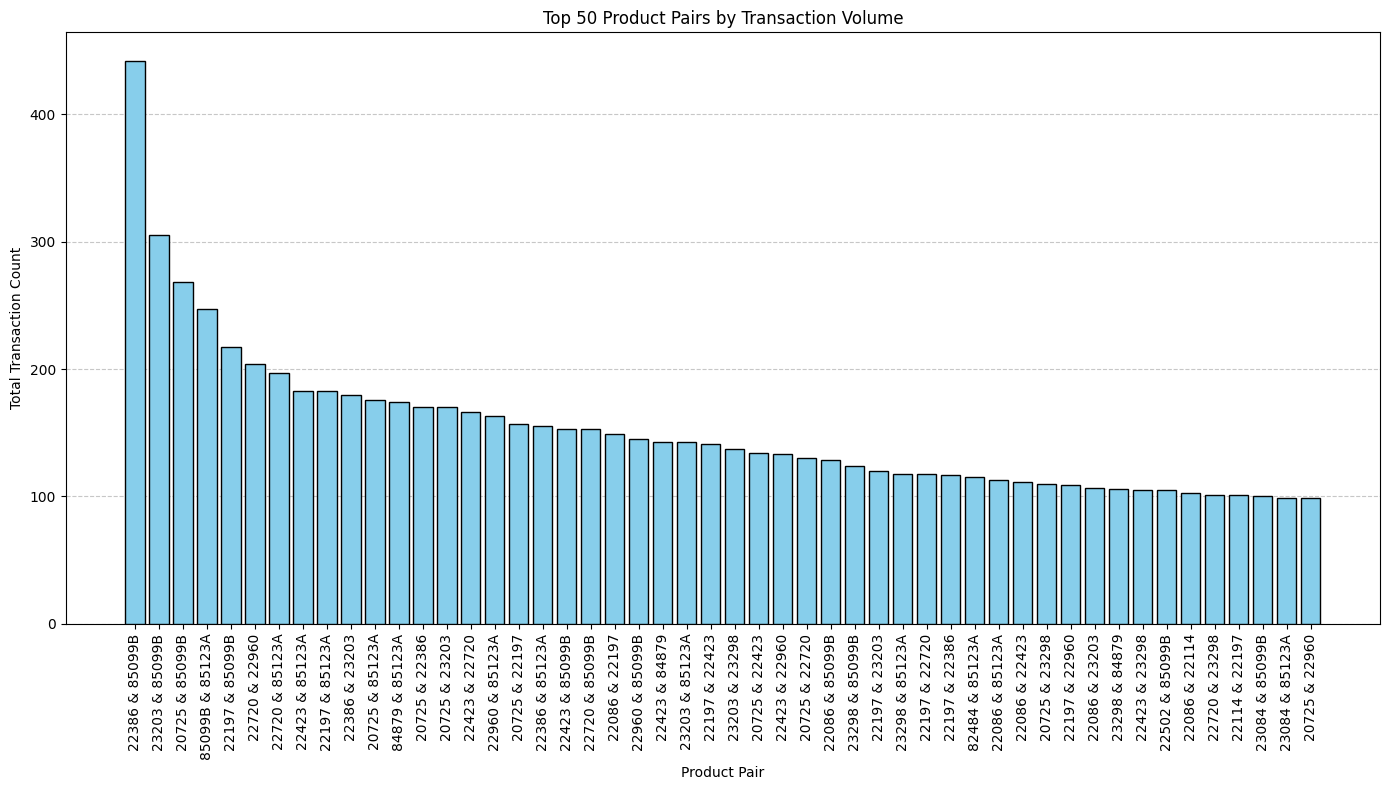

'Descriptive Statistics for Pair Transactions:'

,count_trans_pair
count,743.0
mean,19.141319
std,18.653247
min,1.0
25%,5.0
50%,14.0
75%,27.0
max,131.0


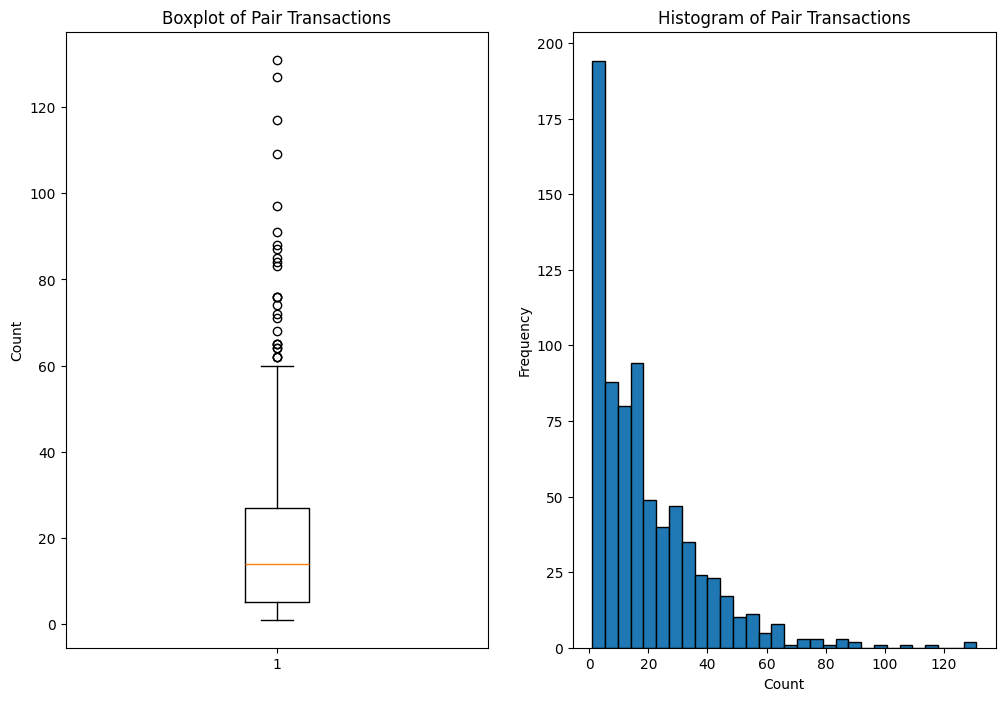

'Descriptive Statistics for Avg. Price of Pairs:'

,avg_price_pair
count,743.000000
mean,35.586372
std,17.037352
min,8.131250
25%,23.537073
50%,32.072844
75%,44.086516
max,97.537725


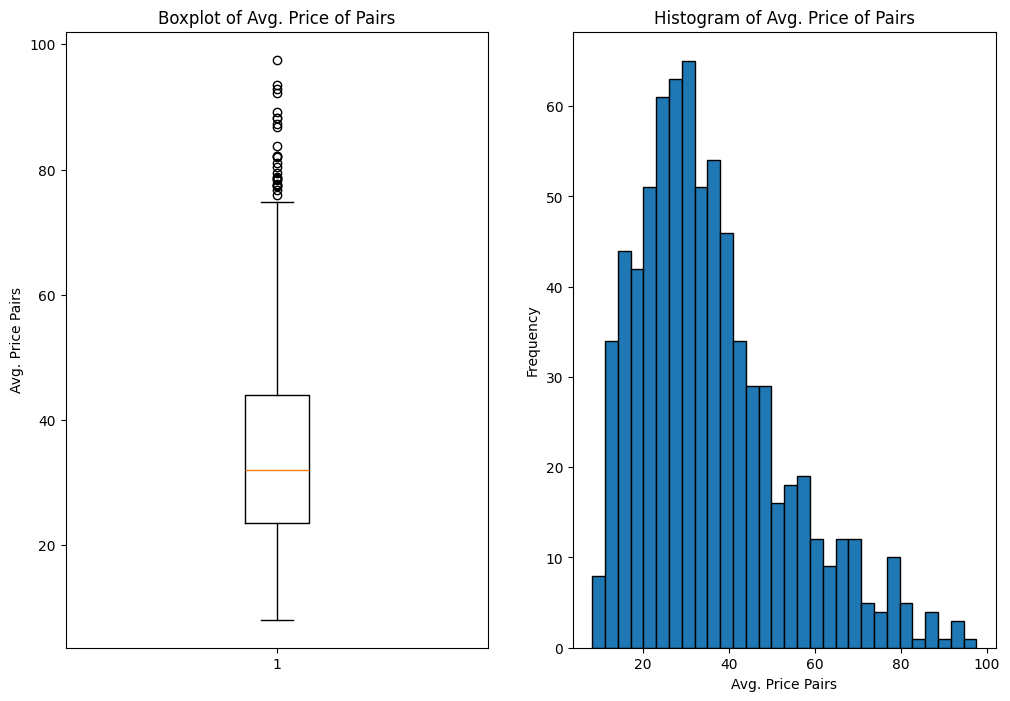

'Descriptive Statistics for Total Sales of Pairs:'

,total_sales_pair
count,743.000000
mean,3325.281642
std,3209.848207
min,49.980000
25%,1104.900000
50%,2275.680000
75%,4535.370000
max,26013.480000


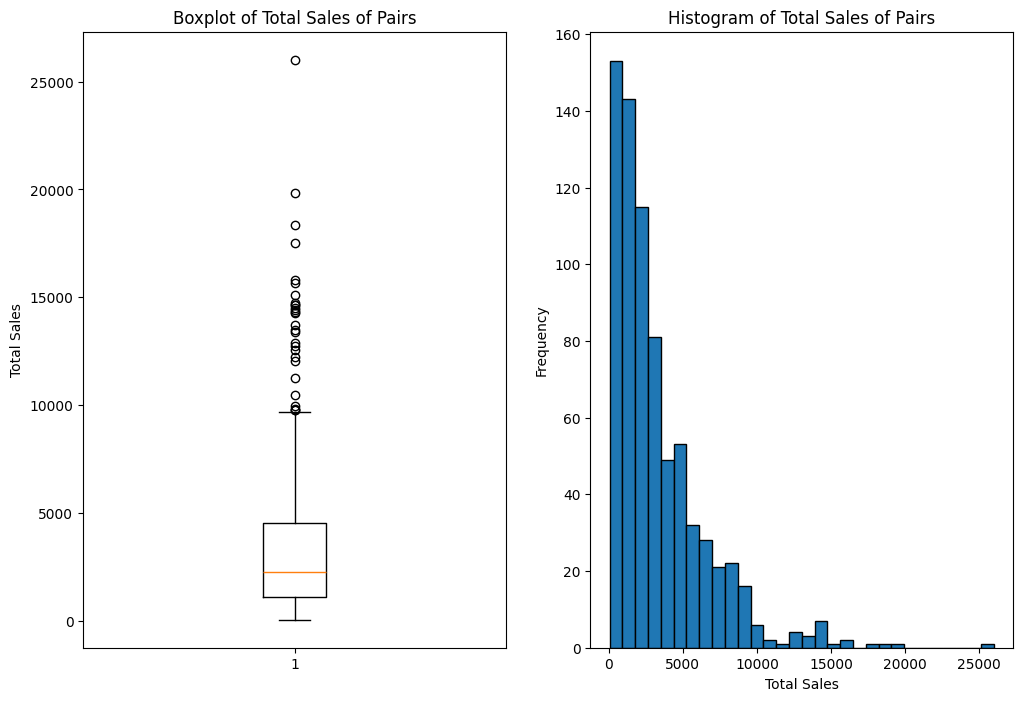

'Descriptive Statistics for Avg. Margin of Pairs:'

,avg_margin_pair
count,743.000000
mean,0.553702
std,0.112447
min,0.113069
25%,0.479898
50%,0.558859
75%,0.629895
max,0.858055


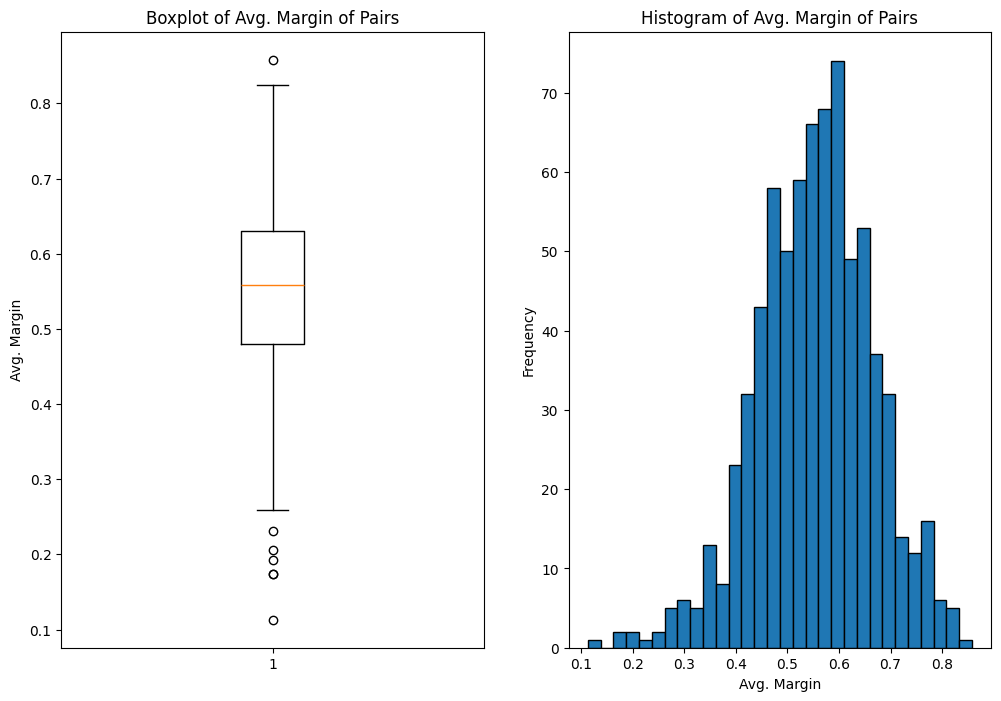

'Descriptive Statistics for Total Profit of Pairs:'

,total_profit_pair
count,743.000000
mean,1917.086487
std,2084.614281
min,23.980000
25%,564.780000
50%,1201.260000
75%,2594.120000
max,19664.480000


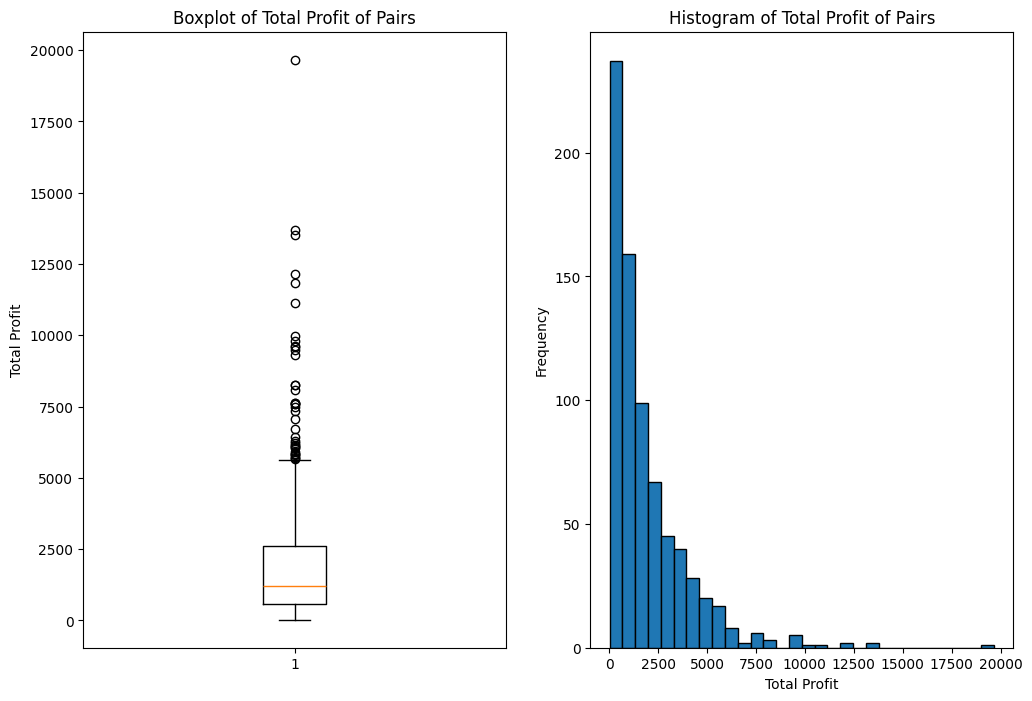

'Descriptive Statistics for Support Product A:'

,support_product_a
count,743.000000
mean,0.091349
std,0.052689
min,0.004074
25%,0.051590
50%,0.089552
75%,0.123333
max,0.219753


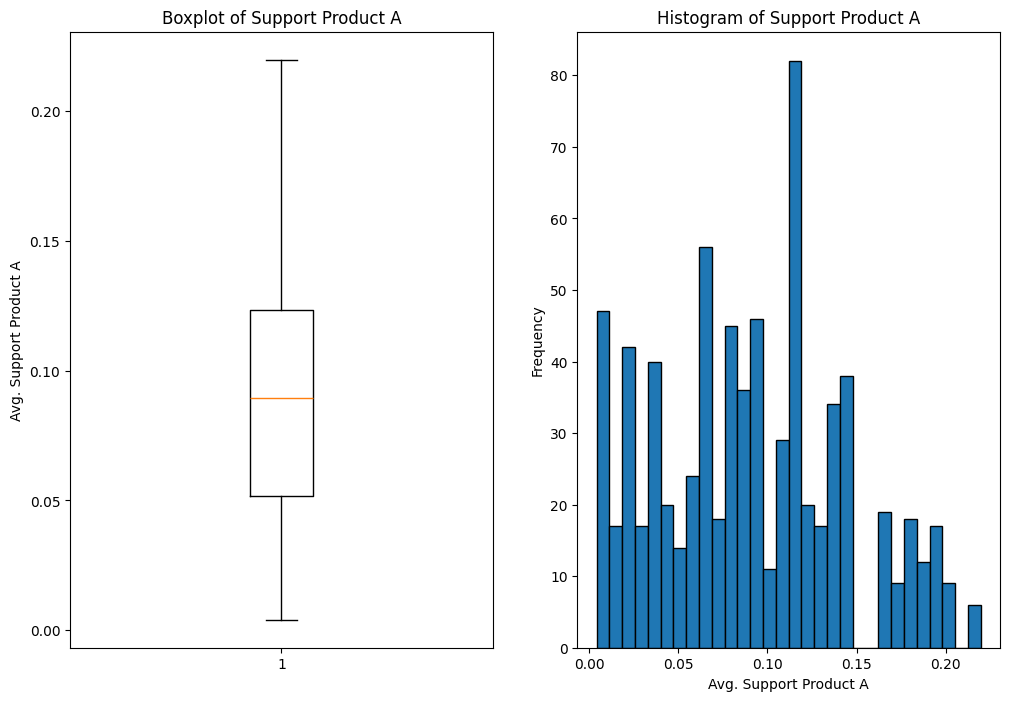

'Descriptive Statistics for Support of Product B:'

,support_product_b
count,743.000000
mean,0.106580
std,0.059505
min,0.001488
25%,0.058519
50%,0.110370
75%,0.142651
max,0.254464


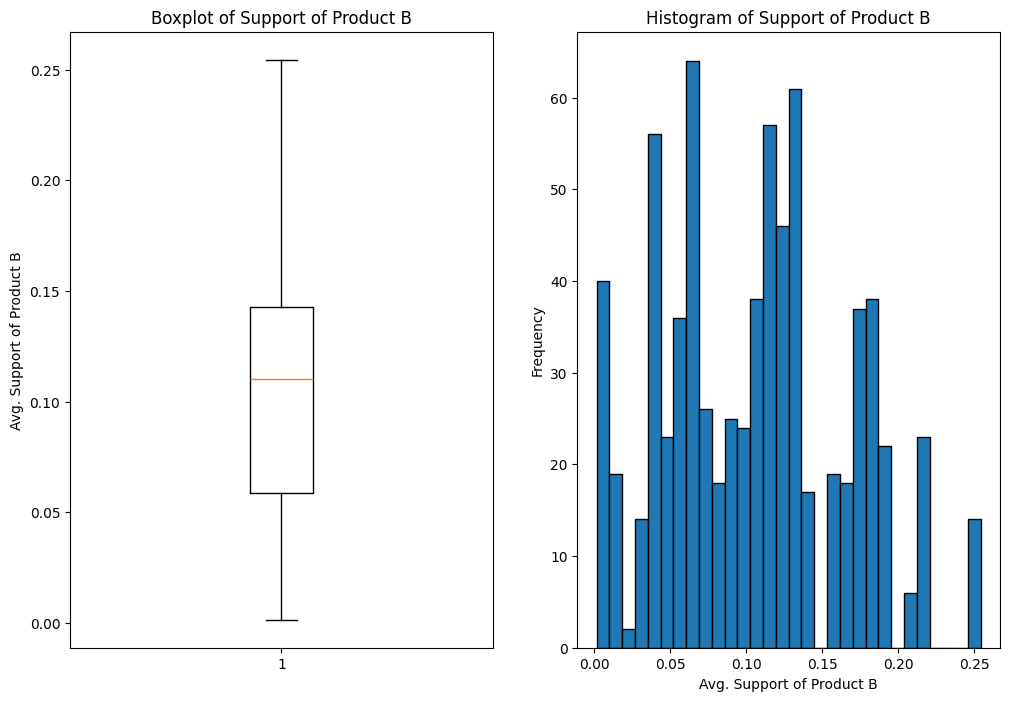

'Descriptive Statistics for Support of Pairs:'

,support_pair
count,743.000000
mean,0.010156
std,0.009248
min,0.000370
25%,0.002882
50%,0.007778
75%,0.014815
max,0.061101


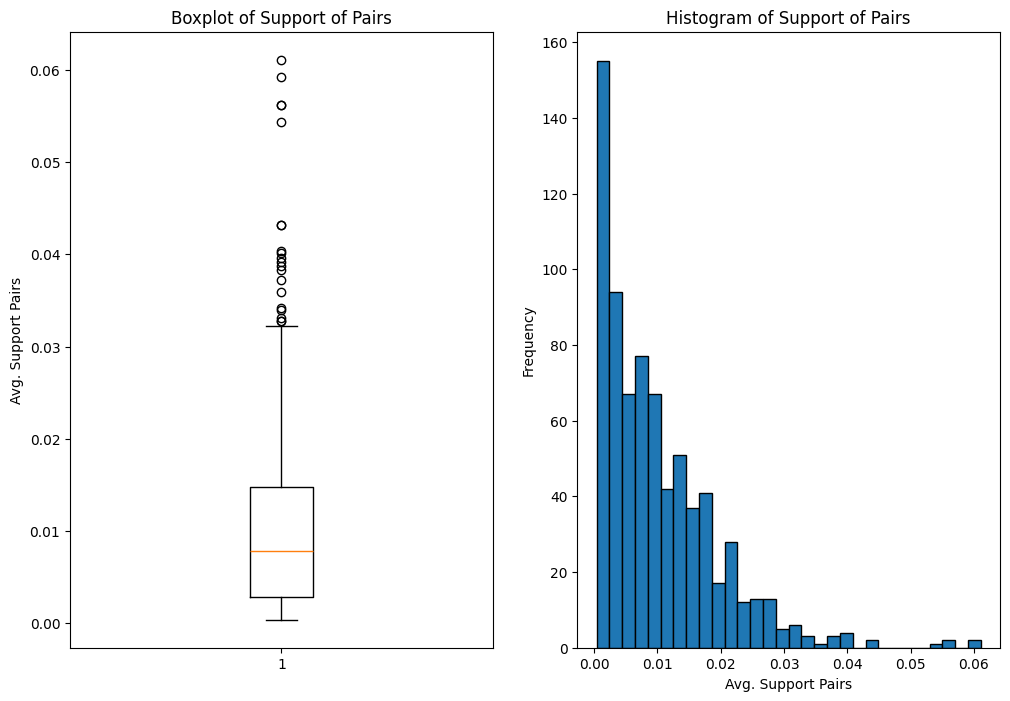

'Descriptive Statistics for Confidence of Pairs:'

,confidence
count,743.000000
mean,0.120984
std,0.089373
min,0.002079
25%,0.060161
50%,0.102564
75%,0.163714
max,0.583333


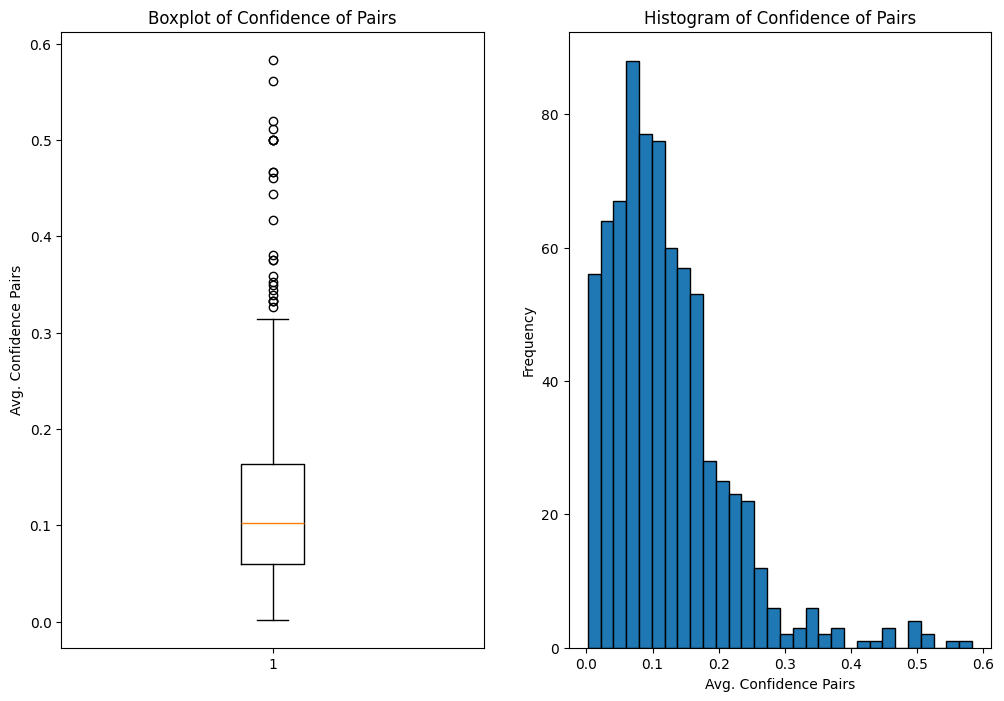

'Descriptive Statistics for Lift of Pairs:'

,lift
count,743.000000
mean,1.260040
std,1.060101
min,0.216634
25%,0.757749
50%,1.023761
75%,1.436708
max,16.390244


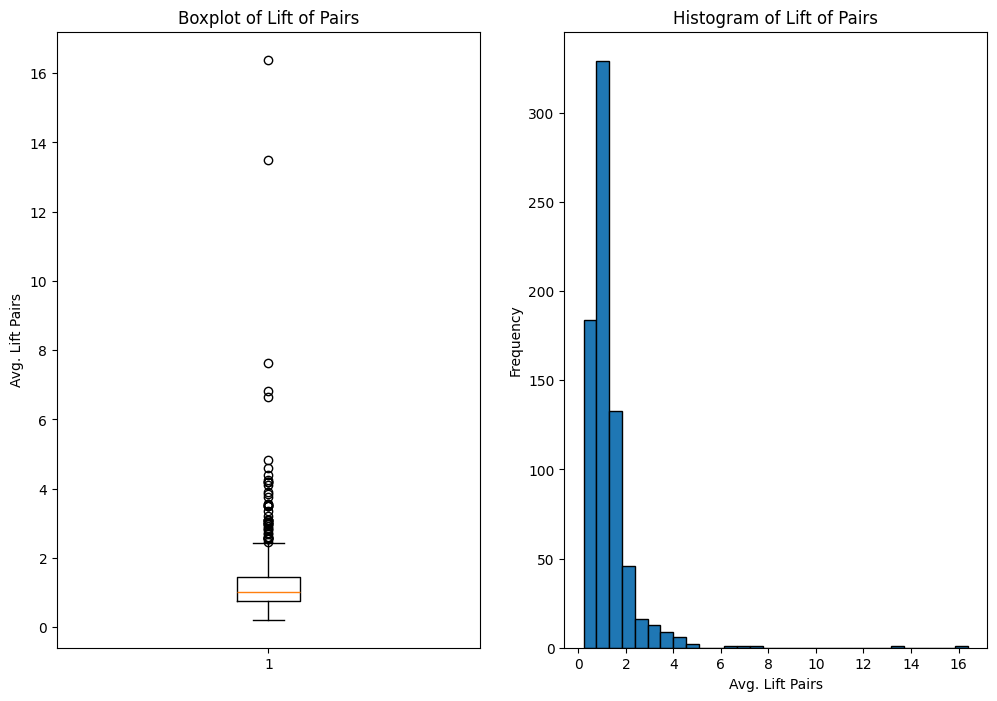

'Descriptive Statistics for Cross_Sell Rate:'

,cross_sell_rate
count,5.000000
mean,0.411985
std,0.043599
min,0.342262
25%,0.414815
50%,0.416049
75%,0.424111
max,0.462687


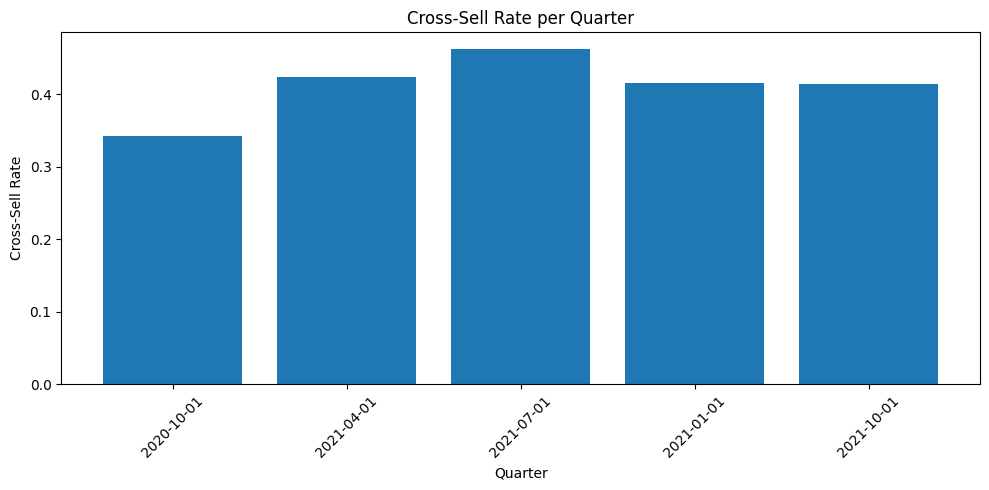

In [58]:

# 1. Check date range of transaction_date

date_min = df_final_table["transaction_quarter"].min()
date_max = df_final_table["transaction_quarter"].max()

display("Date Range of User-Level Data:")
display(f"From: {date_min}")
display(f"To:   {date_max}")

# ------------------------------------------------------------------------------

# 2.0 Countplot for count_trans_pair by product_a + product_b

# Create the pair name first
df_final_table["pair"] = df_final_table["product_a"] + " & " + df_final_table["product_b"]

# IMPORTANT: Aggregate (Group and Sum)

df_grouped = df_final_table.groupby("pair")["count_trans_pair"].sum().reset_index()

# Sort by count and take the Top 50
top_pairs = df_grouped.sort_values("count_trans_pair", ascending=False).head(50)

# Plotting
plt.figure(figsize=(14, 8))

# Grid configuration (behind the bars)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.bar(
    top_pairs["pair"],
    top_pairs["count_trans_pair"],
    color="skyblue",
    edgecolor="black",
    zorder=3 # Ensures bars are drawn on top of the grid
)

# Labels and Titles
plt.title("Top 50 Product Pairs by Transaction Volume")
plt.xlabel("Product Pair")
plt.ylabel("Total Transaction Count")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------

# 3.0 Boxplot, Histogramm, count_trans_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Pair Transactions:")
display(df_final_table["count_trans_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["count_trans_pair"])
plt.title("Boxplot of Pair Transactions")
plt.ylabel("Count")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["count_trans_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Pair Transactions")
plt.xlabel("Count")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.1 Boxplot, Histogramm, avg_price_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Avg. Price of Pairs:")
display(df_final_table["avg_price_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["avg_price_pair"])
plt.title("Boxplot of Avg. Price of Pairs")
plt.ylabel("Avg. Price Pairs")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["avg_price_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Avg. Price of Pairs")
plt.xlabel("Avg. Price Pairs")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.2 Boxplot, Histogramm, total_sales_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Total Sales of Pairs:")
display(df_final_table["total_sales_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["total_sales_pair"])
plt.title("Boxplot of Total Sales of Pairs")
plt.ylabel("Total Sales")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["total_sales_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Total Sales of Pairs")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.3 Boxplot, Histogramm, avg_margin_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Avg. Margin of Pairs:")
display(df_final_table["avg_margin_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["avg_margin_pair"])
plt.title("Boxplot of Avg. Margin of Pairs")
plt.ylabel("Avg. Margin")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["avg_margin_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Avg. Margin of Pairs")
plt.xlabel("Avg. Margin")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.4 Boxplot, Histogramm, total_profit_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Total Profit of Pairs:")
display(df_final_table["total_profit_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["total_profit_pair"])
plt.title("Boxplot of Total Profit of Pairs")
plt.ylabel("Total Profit")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["total_profit_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Total Profit of Pairs")
plt.xlabel("Total Profit")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.5 Boxplot, Histogramm, support_product_a

# Descriptive Statistics
display(f"Descriptive Statistics for Support Product A:")
display(df_final_table["support_product_a"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["support_product_a"])
plt.title("Boxplot of Support Product A")
plt.ylabel("Avg. Support Product A")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["support_product_a"], bins=30, edgecolor="black")
plt.title("Histogram of Support Product A")
plt.xlabel("Avg. Support Product A")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.6 Boxplot, Histogramm, support_product_b

# Descriptive Statistics
display(f"Descriptive Statistics for Support of Product B:")
display(df_final_table["support_product_b"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["support_product_b"])
plt.title("Boxplot of Support of Product B")
plt.ylabel("Avg. Support of Product B")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["support_product_b"], bins=30, edgecolor="black")
plt.title("Histogram of Support of Product B")
plt.xlabel("Avg. Support of Product B")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.7 Boxplot, Histogramm, support_pair

# Descriptive Statistics
display(f"Descriptive Statistics for Support of Pairs:")
display(df_final_table["support_pair"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["support_pair"])
plt.title("Boxplot of Support of Pairs")
plt.ylabel("Avg. Support Pairs")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["support_pair"], bins=30, edgecolor="black")
plt.title("Histogram of Support of Pairs")
plt.xlabel("Avg. Support Pairs")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.8 Boxplot, Histogramm, confidence

# Descriptive Statistics
display(f"Descriptive Statistics for Confidence of Pairs:")
display(df_final_table["confidence"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["confidence"])
plt.title("Boxplot of Confidence of Pairs")
plt.ylabel("Avg. Confidence Pairs")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["confidence"], bins=30, edgecolor="black")
plt.title("Histogram of Confidence of Pairs")
plt.xlabel("Avg. Confidence Pairs")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------

# 3.9 Boxplot, Histogramm, lift by

# Descriptive Statistics
display(f"Descriptive Statistics for Lift of Pairs:")
display(df_final_table["lift"].describe())

plt.figure(figsize=(12, 8))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(df_final_table["lift"])
plt.title("Boxplot of Lift of Pairs")
plt.ylabel("Avg. Lift Pairs")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_final_table["lift"], bins=30, edgecolor="black")
plt.title("Histogram of Lift of Pairs")
plt.xlabel("Avg. Lift Pairs")
plt.ylabel("Frequency")

plt.show()

# ------------------------------------------------------------------------------


# 3.10 Barplot Cross_Sell Rate

# Descriptive Statistics
display(f"Descriptive Statistics for Cross_Sell Rate:")
display(df_csr["cross_sell_rate"].describe())

plt.figure(figsize=(10,5))
plt.bar(df_csr['transaction_quarter'].astype(str), df_csr['cross_sell_rate'])

plt.title("Cross-Sell Rate per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Cross-Sell Rate")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **🔵EDA Conclusions**

### **1. Date Range**  
- Period: **January 10, 2021 – September 9, 2021**  
- ~9 months of user-level transactions  

---

### **13.0 Top Product Pairs by Transaction Volume**

* **Highly concentrated pattern:**   A few product pairs dominate the volume — the top pair exceeds **450 transactions**, far above the average.
* **Steep drop-off:**   After the first three to five pairs, volumes decline quickly, stabilising around **100–200 transactions** for the remaining top 50.
* **Low overall frequency:**  Descriptive statistics show the **average pair only appears ~19 times**, with a median of **14 transactions**, meaning most pairs occur rarely.
* **Main takeaway:**  Cross-selling activity is **heavily driven by a small number of high-performing pairs**,  
  while the majority of combinations contribute marginally and require strategic focus if they are to grow.


---

### **3.0 Distribution of Pair Transaction Counts**

* **Skewed pattern:**  The histogram shows a strong right skew — most product pairs occur only a few times, while only a few pairs appear very often.
* **Low typical frequency:**  The median is **14 transactions**, meaning more than half of all pairs occur fewer than 14 times.
* **Outliers visible:**  The boxplot highlights several pairs with very high counts (60–130 transactions), standing far away from the rest.
* **Overall takeaway:**  Most product pairs are low-frequency, and only a small group performs strongly in cross-selling activity.

---

### **3.1 Distribution of Average Pair Price**

* **Most pairs sit in a mid-price range:**  The median price is around **$32**, showing that typical product pairs fall in a moderate price segment.
* **Right-skewed distribution:**  The histogram shows a slight right skew — lower and mid-priced pairs are more common, while high-priced pairs occur less often.

* **Outliers exist at the high end:**  A few product pairs reach prices above **$75–$95**, which stand out clearly in the boxplot.

* **Overall takeaway:**  Cross-selling combinations are generally mid-priced, but there are a small number of premium pairings with significantly higher price levels.

---

### **3.2 Distribution of Total Sales per Pair**

* **Skewed distribution:**  The histogram shows a strong right skew — many pairs generate low to moderate sales, while only a few reach very high totals.
* **Central tendency is moderate:**  The median sales value is around **$2,276**, meaning half of all pairs generate less than this amount.
* **High variance and outliers:**  Several pairs reach **$10,000–$26,000**, clearly visible as outliers in the boxplot.
* **Overall takeaway:**   Most product pairs produce modest sales figures, but a small group of pairs drives a disproportionately high amount of revenue.

---

### **3.3 Distribution of Average Margin per Pair**

* **Margins cluster around a mid-level:**  The median margin is about **56%**, meaning most product pairs deliver a solid profit level.
* **Fairly concentrated spread:**  The histogram shows a relatively tight range, with many values between **48–63%**, indicating stable margin performance.
* **A few outliers exist:**  Some pairs fall below **25%**, while others reach **80%+**, visible as points outside the main boxplot area.
* **Overall takeaway:**   Most cross-selling pairs achieve healthy and consistent margins, with only a small number performing unusually low or unusually high.

---

### **3.4 Distribution of Total Profit per Pair**

* **Profit values are very uneven:**  
  The distribution is **strongly right-skewed**, meaning only a few pairs earn very high profit.

* **Most product pairs stay modest:**  
  The median profit of around **$1.2k** shows that typical pairs contribute moderate profit.

* **Some pairs generate exceptional profit:**  
  Outliers reach **$10k–$20k**, visible at the top end of the boxplot.

* **Main takeaway:**  
  Cross-selling profit potential exists, but it is concentrated in a **small set of highly valuable product pairs**, while the majority perform at a much lower level.

---

### **3.5 & 3.6 Support Distribution for Products (A & B Combined)**

*Support A and Support B are interpreted together because they describe the same underlying concept —  
how frequently individual products appear in transactions.  
The distinction between A and B exists only due to pair structure, not because they represent different products.*

* **Low overall presence:**   Most products appear in only **5–12%** of transactions, indicating selective or niche buying patterns.
* **Wide variability:**  The spread is broad — while many products have low visibility, a smaller group reaches support levels above **15%**.
* **Few dominant products:**  Outliers exceed **20–25%**, reflecting a small set of highly purchased items.
* **Main takeaway:**   Product frequency in baskets is **uneven but consistently low** across the catalog.  
  This means cross-selling opportunities depend heavily on a **small group of high-exposure products**, while most items require strategic visibility to contribute.

---

### **3.7 Distribution of Pair Support**

* **Very low occurrence overall:**  Most product pairs appear in **less than 1% of transactions**, meaning true co-buying events are rare.
* **Strong skew toward zero:**  The histogram shows a heavy right-skew — the majority of pairs occur extremely infrequently, with only a few gaining notable visibility.
* **Outliers exist but remain small:**  Even the most frequently appearing pairs reach only **6% support**, far below product-level support values.
* **Main takeaway:**   Cross-selling relationships are **weak for most pairs** — only a small number of combinations repeatedly occur in the data.  
  This indicates **high fragmentation of demand** and highlights the importance of identifying the few strong co-purchase patterns.

---

### **3.8 Distribution of Confidence**

* **Generally weak association strength:**  
  Confidence values mostly fall between **6% and 16%**, indicating that product B is rarely purchased after product A.* **Highly skewed distribution:**  
  The histogram shows a heavy right-skew — most pairs exhibit low confidence, while only a few cases reach beyond **30–50%**.
* **Clear outliers:**  A small set of pairs achieves **>40% confidence**, suggesting strong directed buying relationships.
* **Main takeaway:**   Cross-sell dependencies are **weak for most product pairs**,  
  but a **very small group of pairs shows meaningful recommendation potential**.

---

### **11.0 Distribution of Lift**
* **Most relationships are only mildly positive:**  
  The central tendency lies just above **1.0**, meaning most pairs co-occur slightly more often than random chance.
* **Strong right-skew:**   The majority cluster between **0.8 and 1.5**, while a long tail stretches toward **very high Lift values**.
* **Rare but powerful associations:**  Outliers reaching **6–16× expected frequency** indicate a small set of product pairs with exceptionally strong cross-sell behavior.
* **Main takeaway:**  Lift confirms that **true cross-selling strength exists — but only for very few combinations**.  
  For most pairs, the effect is weak to moderate, reinforcing the value of **focusing recommendations on top Lift performers**.

---

### **12.0 Cross-Sell Rate Over Time**

* **Stable behaviour overall:**  The quarterly cross-sell rate ranges narrowly between **34% and 46%**, indicating a steady level of paired purchasing.
* **Noticeable peak mid-period:**  The highest rate occurs in **Q2 2021 (~46%)**, suggesting a temporary rise in co-purchasing activity.
* **Minor softening afterwards:**  Following the peak, the rate settles slightly lower (~41–42%), but remains **above the starting level**.
* **Main takeaway:**  Cross-selling intensity is **consistently strong across periods**, with a **mid-period uplift** that may reflect marketing actions, seasonality, or demand shifts.




# 🟦 **5. Dashboard**

The final dashboard presents the results of this cross-selling analysis in an interactive and business-friendly format.  
It allows users to explore performance trends, key metrics, and product pair insights directly.

🔗 **Access the dashboard:**  
https://lookerstudio.google.com/reporting/8823545f-b537-4607-ae20-4a072a628276

> **Navigation tip:**  
After opening the dashboard, click **More options → Present** to view it in full screen mode for a better experience.